# **SENARYO C**

## Imports

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.opt import TerminationCondition

In [ ]:
!apt-get install -y coinor-cbc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  coinor-libcbc3 coinor-libcgl1 coinor-libclp1 coinor-libcoinutils3v5
  coinor-libosi1v5
The following NEW packages will be installed:
  coinor-cbc coinor-libcbc3 coinor-libcgl1 coinor-libclp1
  coinor-libcoinutils3v5 coinor-libosi1v5
0 upgraded, 6 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,908 kB of archives.
After this operation, 8,310 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 coinor-libcoinutils3v5 amd64 2.11.4+repack1-2 [465 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 coinor-libosi1v5 amd64 0.108.6+repack1-2 [275 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 coinor-libclp1 amd64 1.17.5+repack1-1 [937 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 coinor-libcgl1 amd64 0.60.3+repack1-3 [420 kB]
Get:5 ht

In [ ]:
!apt-get install -y glpk-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev
The following NEW packages will be installed:
  glpk-utils libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
0 upgraded, 5 newly installed, 0 to remove and 35 not upgraded.
Need to get 625 kB of archives.
After this operation, 2,158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.10.1+dfsg-4build1 [21.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libcolamd2 amd64 1:5.10.1+dfsg-4build1 [18.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libglpk40 amd64 5.0-1 [361 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 glpk-ut

## Data

In [ ]:
# Purpose: Load CSV data, combine date and time into datetime, sort by datetime, and create an hourly index.

data_path = 'data.csv'
df = pd.read_csv(data_path)  # Load data from CSV
df['Datetime'] = pd.to_datetime(df['Tarih'] + ' ' + df['Saat'], dayfirst=True)  # Merge date and time into datetime
df = df.sort_values('Datetime').reset_index(drop=True)  # Sort by datetime and reset index
df['t'] = range(len(df))  # Create sequential hourly index

# Result: DataFrame ready with sorted datetime and hourly index 't'.

In [ ]:
df

,Tarih,Saat,Fiyat_(TL/MWh),PV_Üretim_Tahmini_(MWh),Datetime,t
0,01.05.2025,00:00,1499,0.0,2025-05-01 00:00:00,0
1,01.05.2025,01:00,1575,0.0,2025-05-01 01:00:00,1
2,01.05.2025,02:00,1400,0.0,2025-05-01 02:00:00,2
3,01.05.2025,03:00,1400,0.0,2025-05-01 03:00:00,3
4,01.05.2025,04:00,1400,0.7,2025-05-01 04:00:00,4
...,...,...,...,...,...,...
739,31.05.2025,19:00,3390,0.5,2025-05-31 19:00:00,739
740,31.05.2025,20:00,3400,0.0,2025-05-31 20:00:00,740
741,31.05.2025,21:00,3400,0.0,2025-05-31 21:00:00,741
742,31.05.2025,22:00,3080,0.0,2025-05-31 22:00:00,742


## Pyomo Model

### Parameters and Set

In [ ]:
# Purpose: Initialize Pyomo model with time set, define system parameters, and create parameters for price and PV production time series.

model = ConcreteModel()

model.T = RangeSet(0, len(df) - 1)  # Hourly time set

# Fixed system parameters
pv_capacity = 5               # PV capacity in MWh
battery_capacity = 10         # Battery capacity in MWh
battery_power = 5             # Max charge/discharge power in MW
charge_efficiency = 0.90
discharge_efficiency = 0.90
min_soc = 0.10 * battery_capacity  # Minimum state of charge (10%)
max_soc = 0.90 * battery_capacity  # Maximum state of charge (90%)
usage_cost = 600                # Usage cost in TL/MWh
grid_capacity = 8              # Grid capacity in MW
initial_energy = 5             # Initial battery energy in MWh
final_energy = 1               # Final battery energy in MWh

# Time series data
price_series = df["Fiyat_(TL/MWh)"].tolist()
pv_production = df["PV_Üretim_Tahmini_(MWh)"].tolist()

# Pyomo Parameters
model.price = Param(model.T, initialize=lambda model, t: price_series[t])
model.pv = Param(model.T, initialize=lambda model, t: pv_production[t])

# Result: Model initialized with parameters for optimization.

### Variables

In [ ]:
# Purpose: Define continuous decision variables for energy flows and battery state of charge in the model.

model.pv_to_grid = Var(model.T, within=NonNegativeReals)       # Energy from PV to grid (MWh)
model.pv_to_battery = Var(model.T, within=NonNegativeReals)    # Energy from PV to battery (MWh)
model.grid_to_battery = Var(model.T, within=NonNegativeReals)  # Energy from grid to battery (MWh)
model.battery_to_grid = Var(model.T, within=NonNegativeReals)  # Energy from battery to grid (MWh)
model.soc = Var(model.T, within=NonNegativeReals)              # Battery state of charge (MWh)

# Result: Decision variables created to model energy flows and battery SOC at each time step.

### Constraints

In [ ]:
# Purpose: Define constraints for PV allocation, battery SOC dynamics and limits, power limits, grid export/import limits, and initial/final SOC conditions.

def pv_allocation_rule(model, t):
    return model.pv_to_grid[t] + model.pv_to_battery[t] == model.pv[t]  # All PV energy allocated to grid or battery

model.pv_allocation = Constraint(model.T, rule=pv_allocation_rule)

def soc_rule(model, t):
    if t == model.T.first():
        return model.soc[t] == initial_energy \
            + charge_efficiency * (model.pv_to_battery[t] + model.grid_to_battery[t]) \
            - model.battery_to_grid[t] / discharge_efficiency
    else:
        return model.soc[t] == model.soc[t-1] \
            + charge_efficiency * (model.pv_to_battery[t] + model.grid_to_battery[t]) \
            - model.battery_to_grid[t] / discharge_efficiency  # SOC update with charging/discharging efficiencies

model.soc_balance = Constraint(model.T, rule=soc_rule)

def soc_limits_rule(model, t):
    return inequality(min_soc, model.soc[t], max_soc)  # SOC must remain within min and max limits

model.soc_limits = Constraint(model.T, rule=soc_limits_rule)

def battery_power_limit_rule(model, t):
    return model.pv_to_battery[t] + model.grid_to_battery[t] <= battery_power  # Charging power limit

model.battery_charge_limit = Constraint(model.T, rule=battery_power_limit_rule)

def battery_discharge_limit_rule(model, t):
    return model.battery_to_grid[t] <= battery_power  # Discharging power limit

model.battery_discharge_limit = Constraint(model.T, rule=battery_discharge_limit_rule)

def export_limit_rule(model, t):
    return model.pv_to_grid[t] + model.battery_to_grid[t] <= grid_capacity  # Max export power to grid

model.export_limit = Constraint(model.T, rule=export_limit_rule)

def import_limit_rule(model, t):
    return model.grid_to_battery[t] <= grid_capacity  # Max import power from grid

model.import_limit = Constraint(model.T, rule=import_limit_rule)

def initial_soc_rule(model):
    return model.soc[model.T.first()] == initial_energy  # Initial SOC fixed

model.initial_soc = Constraint(rule=initial_soc_rule)

def final_soc_rule(model):
    return model.soc[model.T.last()] == final_energy  # Final SOC fixed

model.final_soc = Constraint(rule=final_soc_rule)

# Result: Model constraints enforce energy balance, battery limits, and grid power constraints for each time step.

### Objective

In [ ]:
# Purpose: Define objective function to maximize net revenue from selling energy minus costs of charging and battery usage.

def objective_rule(model):
    revenue = sum(model.price[t] * (model.pv_to_grid[t] + model.battery_to_grid[t]) for t in model.T)  # Revenue from selling PV and battery energy
    grid_charge_cost = sum(model.price[t] * model.grid_to_battery[t] for t in model.T)                 # Cost of buying energy from grid to charge battery
    battery_use_cost = sum(model.battery_to_grid[t] * usage_cost for t in model.T)                     # Battery usage cost per discharged energy
    return revenue - grid_charge_cost - battery_use_cost

model.objective = Objective(rule=objective_rule, sense=maximize)

# Result: Objective maximizes net profit considering revenues and all relevant costs.

## Solver

In [ ]:
# Purpose: Define solver, solve the model, and check the solution status.

solver = SolverFactory('cbc')  # Use cbc solver or another compatible solver

results = solver.solve(model, tee=True)  # Solve the optimization model with output logging

# Check solution status and print appropriate message
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print("Optimal solution found.")
elif results.solver.termination_condition == TerminationCondition.infeasible:
    print("Model infeasible: Constraints are inconsistent.")
else:
    print("Solver status:", results.solver.status)

# Result: Provides solver feedback on whether an optimal or infeasible solution was obtained.

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpaftmwwae.pyomo.lp -stat=1 -solve -solu /tmp/tmpaftmwwae.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve 1373 (-4581) rows, 2705 (-1015) columns and 4708 (-6453) elements
Statistics for presolved model


Problem has 1373 rows, 2705 columns (1963 with objective) and 4708 elements
There are 852 singletons with objective 
Column breakdown:
481 of type 0.0->inf, 1468 of type 0.0->up, 0 of type lo->inf, 
742 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 14 of type 0.0->1.0 
Row breakdown:
260 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
480 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 7 of type L 0

In [ ]:
# Purpose: Check the solver result status and print the solution summary if an optimal solution is found.

# If the solution is optimal
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print("\n--- Solution Summary ---")
    # Print the objective function value (Net Profit)
    print(f"Objective Function (Net Profit): {model.objective():,.2f} TL")
    # Print total solver execution time
    print(f"Total Solver Time: {results.solver.time:.2f} seconds")

# If the model is infeasible (no feasible solution due to inconsistent constraints)
elif results.solver.termination_condition == TerminationCondition.infeasible:
    print("Model infeasible: Constraints are inconsistent. No solution found.")

# Otherwise, print the solver status
else:
    print("Solver status:", results.solver.status)

# Result: Displays the optimal solution summary, infeasibility warning, or solver status depending on the outcome.


--- Solution Summary ---
Objective Function (Net Profit): 2,425,114.99 TL
Total Solver Time: 0.14 seconds


## Results

### Result Table

In [ ]:
# Purpose: Collect hourly solution values from the optimization model,
# calculate the total battery discharge, and create a DataFrame with results.

results_list = []
total_discharge = 0  # Total battery discharge (MWh)

# Iterate over each time period in the model
for t in model.T:
    # Get battery discharge value (0 if None)
    battery_discharge = model.battery_to_grid[t].value if model.battery_to_grid[t].value is not None else 0
    total_discharge += battery_discharge  # Accumulate total discharge

    # Append results for each hour into a list of dictionaries
    results_list.append({
        'Hour': t,
        'PV_to_Grid_MW': model.pv_to_grid[t].value,       # PV directly to grid
        'PV_to_Battery_MW': model.pv_to_battery[t].value, # PV charging the battery
        'Grid_to_Battery_MW': model.grid_to_battery[t].value, # Grid charging the battery
        'Battery_to_Grid_MW': battery_discharge,          # Battery discharging to grid
        'Battery_SOC_MWh': model.soc[t].value             # State of charge of the battery
    })

# Convert the results list into a pandas DataFrame
df_results = pd.DataFrame(results_list)

# Result: DataFrame (df_results) contains hourly energy flows and battery state of charge,
# and total_discharge holds the cumulative discharged energy.

In [ ]:
# This code extracts hourly data, adds electricity prices, and defines battery usage cost

hours = df_results['Hour']  # Extract hour values from results DataFrame

# Add hourly electricity prices from the model to results DataFrame
# Assumption: model.price is aligned with model.T (same time indices)
df_results['Price_TL_per_MWh'] = [model.price[t] for t in model.T]

# Define battery usage cost parameter (TL/MWh)
battery_usage_cost_per_MWh = 600

# Result: DataFrame now includes hourly prices and a constant battery usage cost parameter is defined

In [ ]:
# This code converts hours into 0–23 format and calculates average values by hour of day

# Convert 'Hour' to 'Hour_of_Day' in 0-23 format
df_results['Hour_of_Day'] = df_results['Hour'] % 24  # Assumes 'Hour' is continuous across days

# Group by hour of the day and compute average for each numeric column
df_grouped = df_results.groupby('Hour_of_Day').mean()

# Result: A new DataFrame with average values for each hour of the day (0–23)

In [ ]:
# This code calculates hourly revenue, costs, and net profit from PV and battery operations

# Calculate hourly revenue from PV and battery electricity sold to the grid
df_results['Revenue_TL'] = df_results['Price_TL_per_MWh'] * (df_results['PV_to_Grid_MW'] + df_results['Battery_to_Grid_MW'])

# Calculate hourly grid charging cost (buying electricity from grid to charge battery)
df_results['Grid_Charge_Cost_TL'] = df_results['Price_TL_per_MWh'] * df_results['Grid_to_Battery_MW']

# Calculate hourly battery usage cost
df_results['Battery_Usage_Cost_TL'] = df_results['Battery_to_Grid_MW'] * usage_cost

# Calculate hourly net profit
df_results['Net_Profit_TL'] = df_results['Revenue_TL'] - df_results['Grid_Charge_Cost_TL'] - df_results['Battery_Usage_Cost_TL']

# Result: DataFrame now includes revenue, grid charging cost, battery usage cost, and net profit for each hour

In [ ]:
# This code classifies each hour into High, Mid, or Low price levels based on percentiles

# Extract hourly electricity prices
price_series = df_results['Price_TL_per_MWh']

# Define thresholds using 75th percentile (High) and 25th percentile (Low)
high_threshold = np.percentile(price_series, 75)
low_threshold = np.percentile(price_series, 25)

# Initialize all hours as 'Mid'
df_results['Price_Level'] = 'Mid'

# Assign 'High' to hours where price is greater than or equal to the 75th percentile
df_results.loc[df_results['Price_TL_per_MWh'] >= high_threshold, 'Price_Level'] = 'High'

# Assign 'Low' to hours where price is less than or equal to the 25th percentile
df_results.loc[df_results['Price_TL_per_MWh'] <= low_threshold, 'Price_Level'] = 'Low'

# Result: DataFrame now includes a 'Price_Level' column indicating High, Mid, or Low price hours

In [ ]:
# This code classifies each hour into High, Mid, or Low PV production levels based on percentiles

# Extract PV production series
prod_series = df['PV_Üretim_Tahmini_(MWh)']

# Define thresholds: 75th percentile for High, 50th percentile for Low (note: median used for Low)
high_threshold = np.percentile(prod_series, 75)
low_threshold = np.percentile(prod_series, 50)

# Initialize all hours as 'Mid'
df_results['Prod_Level'] = 'Mid'

# Assign 'High' to hours with PV production >= 75th percentile
df_results.loc[df['PV_Üretim_Tahmini_(MWh)'] >= high_threshold, 'Prod_Level'] = 'High'

# Assign 'Low' to hours with PV production <= 50th percentile
df_results.loc[df['PV_Üretim_Tahmini_(MWh)'] <= low_threshold, 'Prod_Level'] = 'Low'

# Result: DataFrame now includes 'Prod_Level' column indicating High, Mid, or Low PV production hours

In [ ]:
df_results

,Hour,PV_to_Grid_MW,PV_to_Battery_MW,Grid_to_Battery_MW,Battery_to_Grid_MW,Battery_SOC_MWh,Price_TL_per_MWh,Hour_of_Day,Revenue_TL,Grid_Charge_Cost_TL,Battery_Usage_Cost_TL,Net_Profit_TL,Price_Level,Prod_Level
0,0,0.0,0.0,0.0,0.0,5.000000,1499,0,0.0,0.0,0.0,0.0,Low,Low
1,1,0.0,0.0,0.0,3.6,1.000000,1575,1,5670.0,0.0,2160.0,3510.0,Low,Low
2,2,0.0,0.0,0.0,0.0,1.000000,1400,2,0.0,0.0,0.0,0.0,Low,Low
3,3,0.0,0.0,0.0,0.0,1.000000,1400,3,0.0,0.0,0.0,0.0,Low,Low
4,4,0.7,0.0,0.0,0.0,1.000000,1400,4,980.0,0.0,0.0,980.0,Low,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,739,0.5,0.0,0.0,0.0,9.000000,3390,19,1695.0,0.0,0.0,1695.0,High,Low
740,740,0.0,0.0,0.0,5.0,3.444444,3400,20,17000.0,0.0,3000.0,14000.0,High,Low
741,741,0.0,0.0,0.0,2.2,1.000000,3400,21,7480.0,0.0,1320.0,6160.0,High,Low
742,742,0.0,0.0,0.0,0.0,1.000000,3080,22,0.0,0.0,0.0,0.0,Mid,Low


In [66]:
helper1 = {
    'PV_to_Grid_MW': (df_results['PV_to_Grid_MW'] != 0).sum(),
    'PV_to_Battery_MW': (df_results['PV_to_Battery_MW'] != 0).sum(),
    'Grid_to_Battery_MW': (df_results['Grid_to_Battery_MW'] != 0).sum(),
    'Battery_to_Grid_MW': (df_results['Battery_to_Grid_MW'] != 0).sum()
}

print(helper1)

{'PV_to_Grid_MW': np.int64(409), 'PV_to_Battery_MW': np.int64(78), 'Grid_to_Battery_MW': np.int64(71), 'Battery_to_Grid_MW': np.int64(86)}


In [70]:
# Her sütun için saat bazında 0 olmayan değerleri say
helper2 = df_results.groupby('Hour_of_Day').apply(
    lambda x: pd.Series({
        'PV_to_Grid_MW': (x['PV_to_Grid_MW'] != 0).sum(),
        'PV_to_Battery_MW': (x['PV_to_Battery_MW'] != 0).sum(),
        'Grid_to_Battery_MW': (x['Grid_to_Battery_MW'] != 0).sum(),
        'Battery_to_Grid_MW': (x['Battery_to_Grid_MW'] != 0).sum()
    })
)

helper2

/tmp/ipython-input-3510890467.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,PV_to_Grid_MW,PV_to_Battery_MW,Grid_to_Battery_MW,Battery_to_Grid_MW
Hour_of_Day,,,,
0,0,0,0,0
1,0,0,0,1
2,0,0,0,0
3,0,0,0,0
4,29,0,0,0
5,29,0,0,0
6,27,3,3,0
7,11,19,19,0
8,30,0,0,18


In [ ]:
# This code generates a summary statistics table for all numeric columns in the DataFrame

# Compute descriptive statistics and transpose for easier reading
df_results.describe().T

# Result: Table showing count, mean, std, min, 25%, 50%, 75%, and max for each numeric column

,count,mean,std,min,25%,50%,75%,max
Hour,744.0,371.500000,214.918589,0.0,185.75,371.5,557.25,743.0
PV_to_Grid_MW,744.0,1.161918,1.509296,0.0,0.00,0.3,2.10,5.0
PV_to_Battery_MW,744.0,0.302330,0.955495,0.0,0.00,0.0,0.00,5.0
Grid_to_Battery_MW,744.0,0.183781,0.661514,0.0,0.00,0.0,0.00,4.5
Battery_to_Grid_MW,744.0,0.398589,1.201545,0.0,0.00,0.0,0.00,5.0
Battery_SOC_MWh,744.0,3.385753,3.237672,1.0,1.00,1.0,5.50,9.0
Price_TL_per_MWh,744.0,2458.154570,1002.395757,14.0,1799.00,2887.0,3250.00,3400.0
Hour_of_Day,744.0,11.500000,6.926843,0.0,5.75,11.5,17.25,23.0
Revenue_TL,744.0,3697.096550,5345.131955,0.0,0.00,877.5,5746.35,27200.0
Grid_Charge_Cost_TL,744.0,198.380167,845.648966,0.0,0.00,0.0,0.00,7646.5


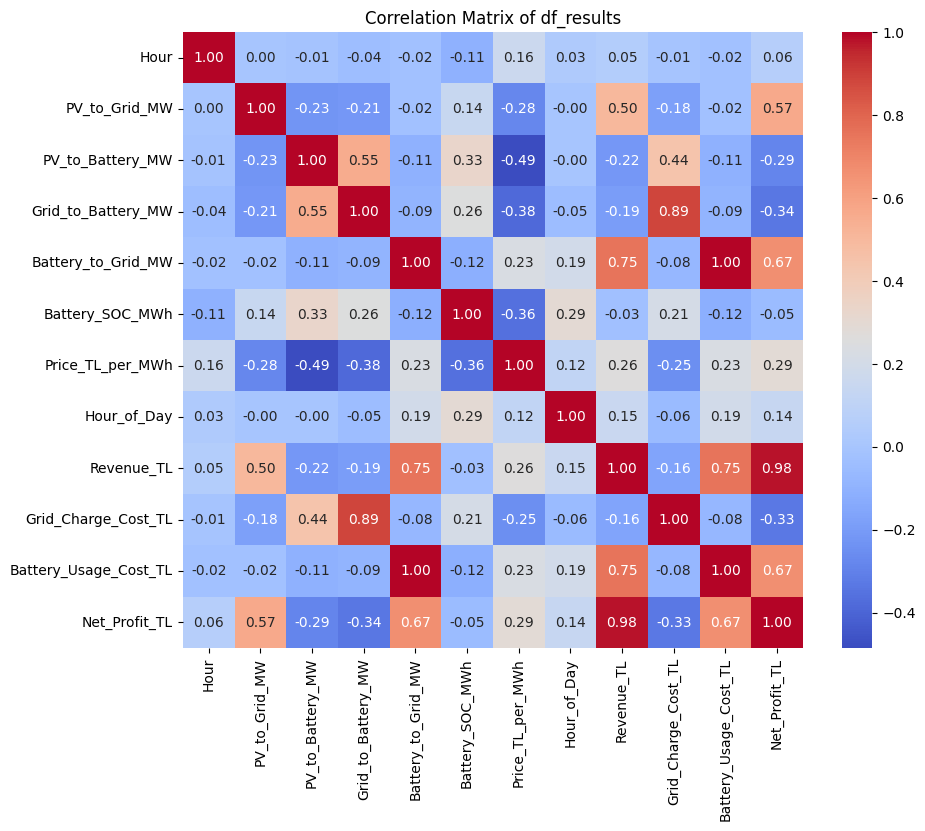

In [ ]:
# This code computes and visualizes the correlation matrix of numeric columns in df_results

# 1. Select numeric columns
numeric_cols = df_results.select_dtypes(include='number')

# 2. Compute correlation matrix
corr_matrix = numeric_cols.corr()

# 3. Visualize correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of df_results")
plt.show()

# Result: Heatmap showing pairwise correlations between all numeric columns

### Hourly Metrics

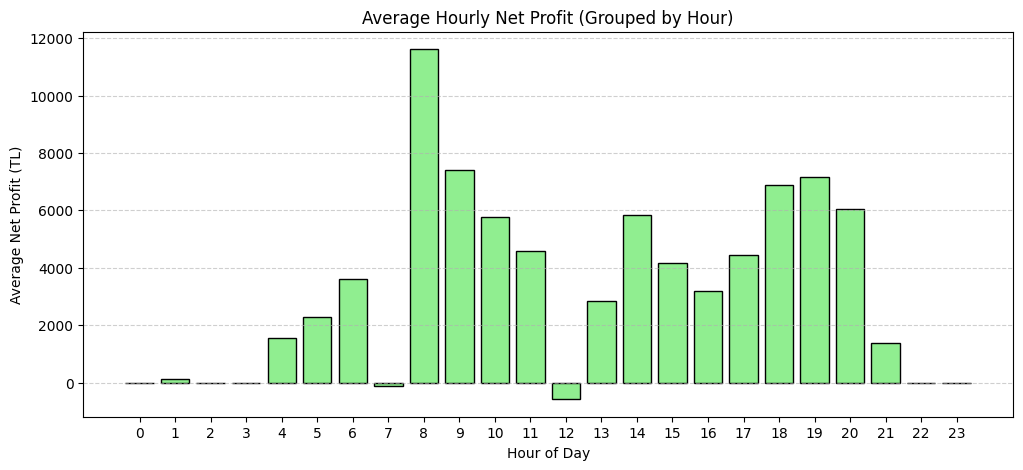

In [ ]:
# This code calculates average net profit by hour and visualizes it as a bar chart
# 1. Compute average net profit for each hour
df_hourly_profit = df_results.groupby('Hour_of_Day')['Net_Profit_TL'].mean().reset_index()

# 2. Plot hourly average net profit as a bar chart
plt.figure(figsize=(12,5))
plt.bar(df_hourly_profit['Hour_of_Day'], df_hourly_profit['Net_Profit_TL'],
        color="lightgreen", edgecolor="black")
plt.xlabel("Hour of Day")
plt.ylabel("Average Net Profit (TL)")
plt.title("Average Hourly Net Profit (Grouped by Hour)")
plt.xticks(range(0,24))
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.show()

# Result: Bar chart showing average net profit for each hour of the day

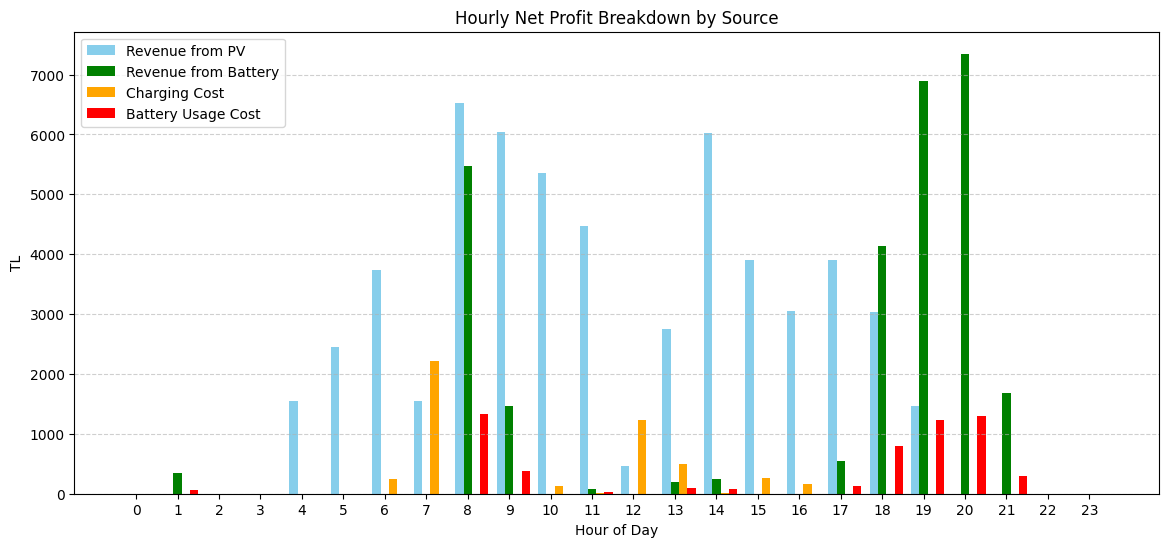

In [ ]:
# This code calculates hourly average PV and battery revenues and costs, then visualizes them

# 1. Compute hourly average values for PV, battery, price, costs, and net profit
df_hourly_breakdown = df_results.groupby('Hour_of_Day').agg({
    'PV_to_Grid_MW': 'mean',
    'Battery_to_Grid_MW': 'mean',
    'Price_TL_per_MWh': 'mean',
    'Grid_Charge_Cost_TL': 'mean',
    'Battery_Usage_Cost_TL': 'mean',
    'Net_Profit_TL': 'mean'
}).reset_index()

# Calculate revenue from PV and battery separately
df_hourly_breakdown['Revenue_PV_TL'] = df_hourly_breakdown['PV_to_Grid_MW'] * df_hourly_breakdown['Price_TL_per_MWh']
df_hourly_breakdown['Revenue_Battery_TL'] = df_hourly_breakdown['Battery_to_Grid_MW'] * df_hourly_breakdown['Price_TL_per_MWh']

# 2. Plot stacked bar chart showing revenue and cost breakdown by hour
plt.figure(figsize=(14,6))
width = 0.2
hours_plot = df_hourly_breakdown['Hour_of_Day']

plt.bar(hours_plot - width, df_hourly_breakdown['Revenue_PV_TL'], width=width, label='Revenue from PV', color='skyblue')
plt.bar(hours_plot, df_hourly_breakdown['Revenue_Battery_TL'], width=width, label='Revenue from Battery', color='green')
plt.bar(hours_plot + width, df_hourly_breakdown['Grid_Charge_Cost_TL'], width=width, label='Charging Cost', color='orange')
plt.bar(hours_plot + 2*width, df_hourly_breakdown['Battery_Usage_Cost_TL'], width=width, label='Battery Usage Cost', color='red')

plt.xlabel("Hour of Day")
plt.ylabel("TL")
plt.title("Hourly Net Profit Breakdown by Source")
plt.xticks(range(0,24))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Result: Bar chart showing hourly revenue from PV, revenue from battery, charging cost, and battery usage cost


### PV Analysis

In [ ]:
# This code checks total PV generation vs. total usage (Grid + Battery) and validates allocation

# Total PV generation from forecast
total_pv_generated = df["PV_Üretim_Tahmini_(MWh)"].sum()

# Total PV used (sent to Grid + stored in Battery)
total_pv_used = (df_results['PV_to_Grid_MW'] + df_results['PV_to_Battery_MW']).sum()

# Print results
print(f"Total PV Generation: {total_pv_generated:.2f} MWh")
print(f"Total PV Used (Grid + Battery): {total_pv_used:.2f} MWh")

# Check if PV allocation rule is satisfied
if abs(total_pv_generated - total_pv_used) < 1e-6:
    print("PV allocation rule correctly applied (Total PV usage equals generation).")
else:
    print("WARNING: Inconsistency in PV allocation detected!")

# Result: Verifies that total PV generation matches total usage, ensuring correct allocation

Total PV Generation: 1089.40 MWh
Total PV Used (Grid + Battery): 1089.40 MWh
PV allocation rule correctly applied (Total PV usage equals generation).


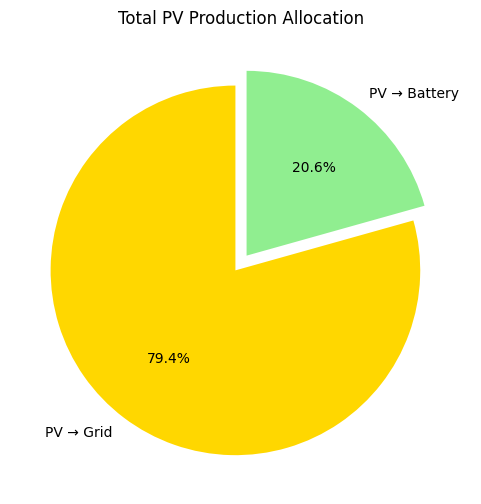

In [ ]:
# Purpose: Visualize the overall allocation of PV production between grid supply and battery storage.

# 1. Compute total PV allocation
total_pv_to_grid = df_results['PV_to_Grid_MW'].sum()
total_pv_to_battery = df_results['PV_to_Battery_MW'].sum()

# 2. Pie Chart: PV Distribution (Grid vs Battery)
plt.figure(figsize=(6, 6))
plt.pie(
    [total_pv_to_grid, total_pv_to_battery],
    labels=['PV → Grid', 'PV → Battery'],
    autopct='%1.1f%%',
    colors=['gold', 'lightgreen'],
    startangle=90,
    explode=(0.05, 0.05)
)
plt.title('Total PV Production Allocation')
plt.show()

# Result:
# Pie chart shows the proportion of PV energy sent directly to the grid versus stored in the battery.

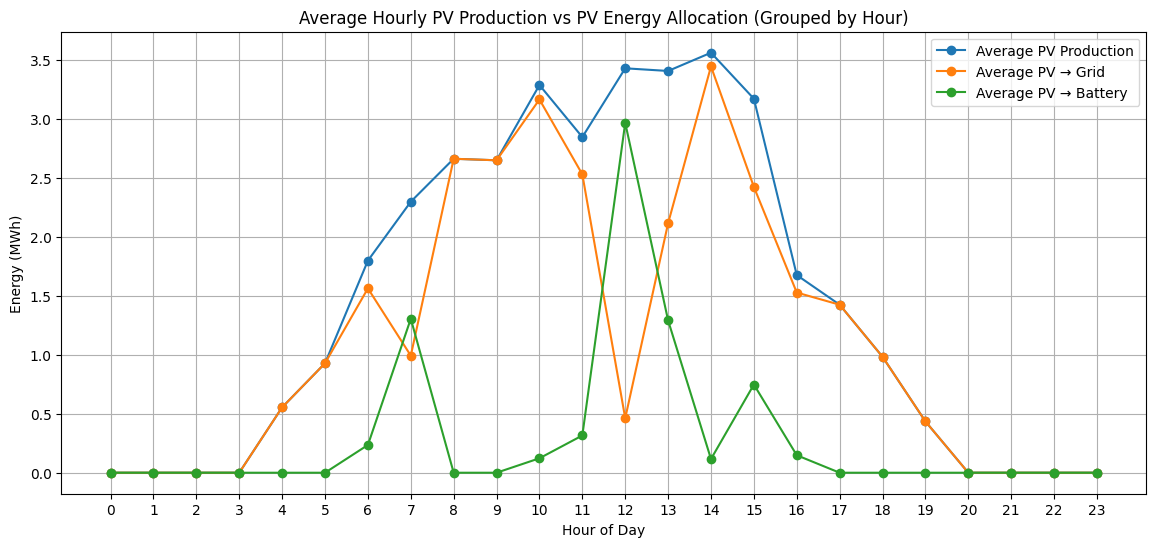

In [ ]:
# This code visualizes average hourly PV production and its allocation to Grid and Battery

plt.figure(figsize=(14,6))

# Plot average PV production (use PV_Üretim_MWh if exists, otherwise sum of PV to Grid and Battery)
plt.plot(df_grouped.index,
         df_grouped['PV_Üretim_MWh'] if 'PV_Üretim_MWh' in df_grouped.columns
         else df_grouped['PV_to_Grid_MW'] + df_grouped['PV_to_Battery_MW'],
         label='Average PV Production', marker='o')

# Plot average PV sent to Grid
plt.plot(df_grouped.index, df_grouped['PV_to_Grid_MW'], label='Average PV → Grid', marker='o')

# Plot average PV sent to Battery
plt.plot(df_grouped.index, df_grouped['PV_to_Battery_MW'], label='Average PV → Battery', marker='o')

plt.xlabel('Hour of Day')
plt.ylabel('Energy (MWh)')
plt.title('Average Hourly PV Production vs PV Energy Allocation (Grouped by Hour)')
plt.xticks(range(0,24))
plt.legend()
plt.grid(True)
plt.show()

# Result: Line chart showing average PV production and how it is split between Grid and Battery by hour

In [ ]:
# Her sütun için saat bazında 0 olmayan değerleri say
non_zero_by_hour = df_results.groupby('Hour_of_Day').apply(
    lambda x: pd.Series({
        'PV_to_Grid_MW': (x['PV_to_Grid_MW'] != 0).sum(),
        'PV_to_Battery_MW': (x['PV_to_Battery_MW'] != 0).sum(),
        'Grid_to_Battery_MW': (x['Grid_to_Battery_MW'] != 0).sum(),
        'Battery_to_Grid_MW': (x['Battery_to_Grid_MW'] != 0).sum()
    })
)

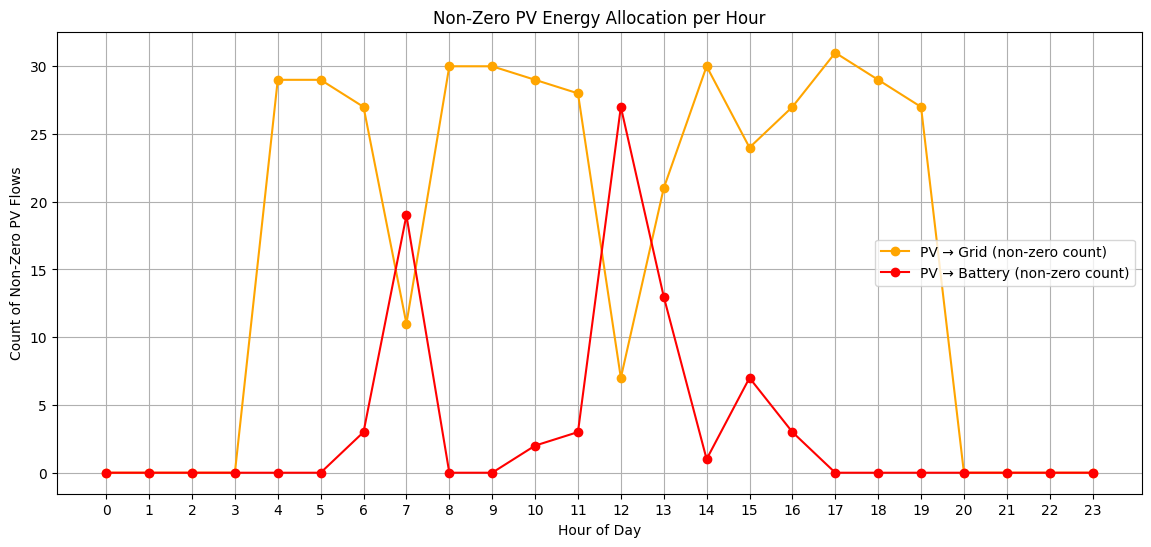

In [71]:
# Non-zero counts per hour using original hourly data
non_zero_pv = df_results.groupby('Hour_of_Day')[['PV_to_Grid_MW', 'PV_to_Battery_MW']].apply(lambda x: (x != 0).sum())

plt.figure(figsize=(14,6))

plt.plot(non_zero_pv.index, non_zero_pv['PV_to_Grid_MW'], label='PV → Grid (non-zero count)', marker='o', color='orange')
plt.plot(non_zero_pv.index, non_zero_pv['PV_to_Battery_MW'], label='PV → Battery (non-zero count)', marker='o', color='red')

plt.xlabel('Hour of Day')
plt.ylabel('Count of Non-Zero PV Flows')
plt.title('Non-Zero PV Energy Allocation per Hour')
plt.xticks(range(0,24))
plt.legend()
plt.grid(True)
plt.show()

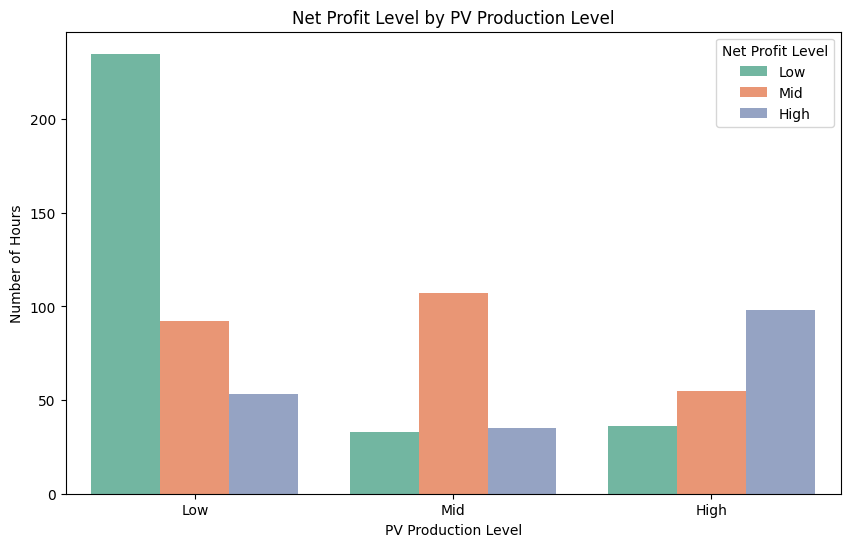

In [ ]:
# This code classifies net profit into High, Mid, Low levels and visualizes its relationship with PV production levels

# 1. Compute percentiles for Net Profit
profit_series = df_results['Net_Profit_TL']
high_profit = np.percentile(profit_series, 75)
low_profit = np.percentile(profit_series, 25)

# 2. Create Net Profit Level column
df_results['Net_Profit_Level'] = 'Mid'
df_results.loc[profit_series >= high_profit, 'Net_Profit_Level'] = 'High'
df_results.loc[profit_series <= low_profit, 'Net_Profit_Level'] = 'Low'

# 3. Plot relationship between PV Production Level and Net Profit Level
plt.figure(figsize=(10,6))
sns.countplot(x='Prod_Level', hue='Net_Profit_Level', data=df_results, palette='Set2')
plt.title('Net Profit Level by PV Production Level')
plt.xlabel('PV Production Level')
plt.ylabel('Number of Hours')
plt.legend(title='Net Profit Level')
plt.show()

# Result: Bar chart showing the distribution of Net Profit Levels for each PV Production Level

In [ ]:
# This code calculates correlation between PV production and battery charging/discharging

# Correlation between PV production and battery charging (PV → Battery)
corr_pv_battery_charge = pd.concat([df['PV_Üretim_Tahmini_(MWh)'], df_results['PV_to_Battery_MW']], axis=1).corr().iloc[0,1]

# Correlation between PV production and battery discharging (Battery → Grid)
corr_pv_battery_discharge = pd.concat([df['PV_Üretim_Tahmini_(MWh)'], df_results['Battery_to_Grid_MW']], axis=1).corr().iloc[0,1]

# Print results
print(f"Correlation PV production vs Battery Charge: {corr_pv_battery_charge:.2f}")
print(f"Correlation PV production vs Battery Discharge: {corr_pv_battery_discharge:.2f}")

# Result: Displays how strongly PV production is correlated with battery charging and discharging

Correlation PV production vs Battery Charge: 0.39
Correlation PV production vs Battery Discharge: -0.09


### Grid Analysis

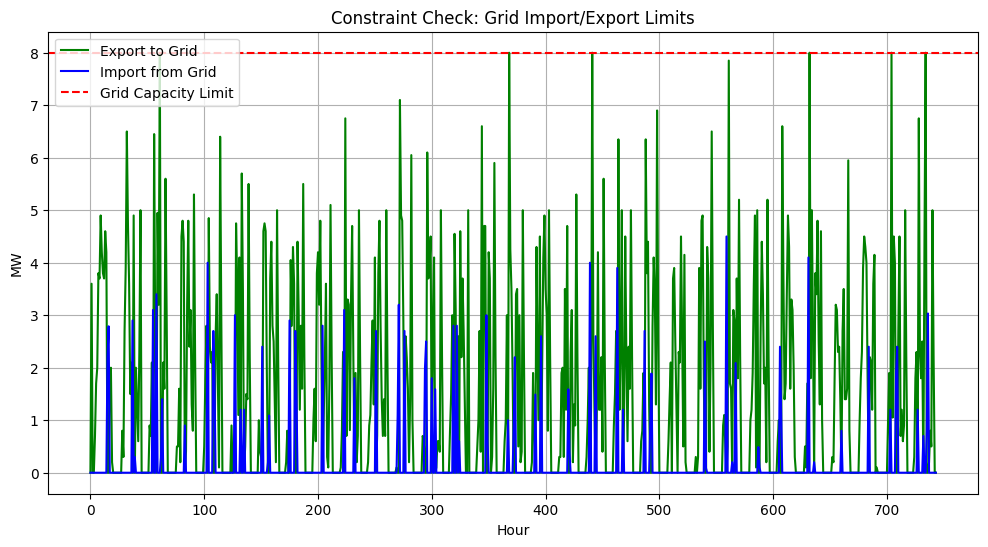

In [ ]:
# This code visualizes hourly grid import/export and checks against grid capacity limit

plt.figure(figsize=(12,6))

# Plot total electricity exported to the grid (PV + Battery)
plt.plot(hours, df_results['PV_to_Grid_MW'] + df_results['Battery_to_Grid_MW'],
         label="Export to Grid", color="green")

# Plot electricity imported from grid to charge battery
plt.plot(hours, df_results['Grid_to_Battery_MW'],
         label="Import from Grid", color="blue")

# Plot grid capacity limit
plt.axhline(y=grid_capacity, color="red", linestyle="--", label="Grid Capacity Limit")

plt.title("Constraint Check: Grid Import/Export Limits")
plt.xlabel("Hour")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()

# Result: Line chart showing grid import/export vs. grid capacity to verify constraint compliance

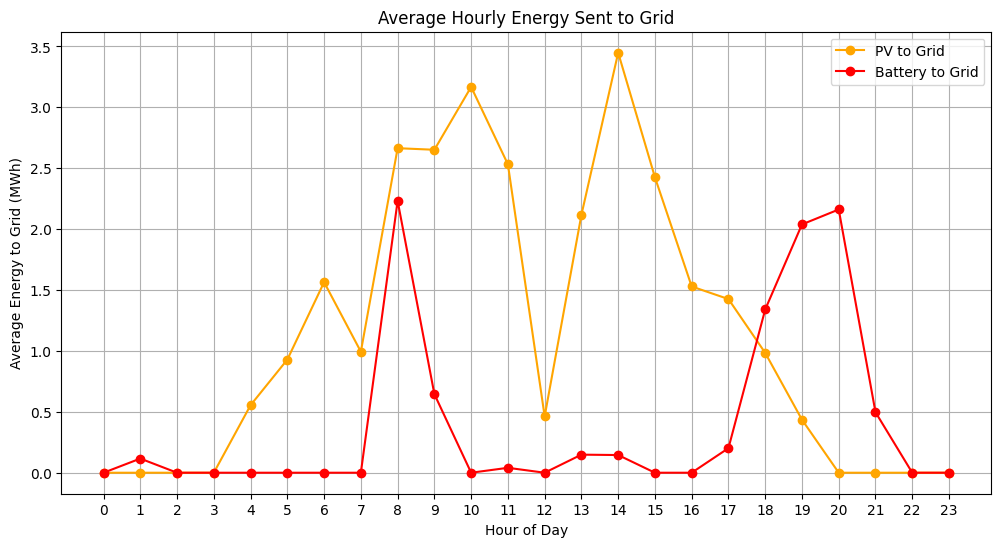

In [ ]:
# Calculate average hourly energy flows from PV and Battery to the grid
hourly_avg = df_results.groupby('Hour_of_Day')[['PV_to_Grid_MW', 'Battery_to_Grid_MW']].mean()

# --- Plot average hourly energy sent to the grid from PV and Battery ---
plt.figure(figsize=(12,6))
plt.plot(hourly_avg.index, hourly_avg['PV_to_Grid_MW'], label='PV to Grid', color='orange', marker='o')
plt.plot(hourly_avg.index, hourly_avg['Battery_to_Grid_MW'], label='Battery to Grid', color='red', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy to Grid (MWh)')
plt.title('Average Hourly Energy Sent to Grid')
plt.xticks(range(0,24))  # Add hours 0-23 to x-axis
plt.legend()
plt.grid(True)
plt.show()

# Result: Line plot showing average hourly energy sent to the grid by PV and Battery

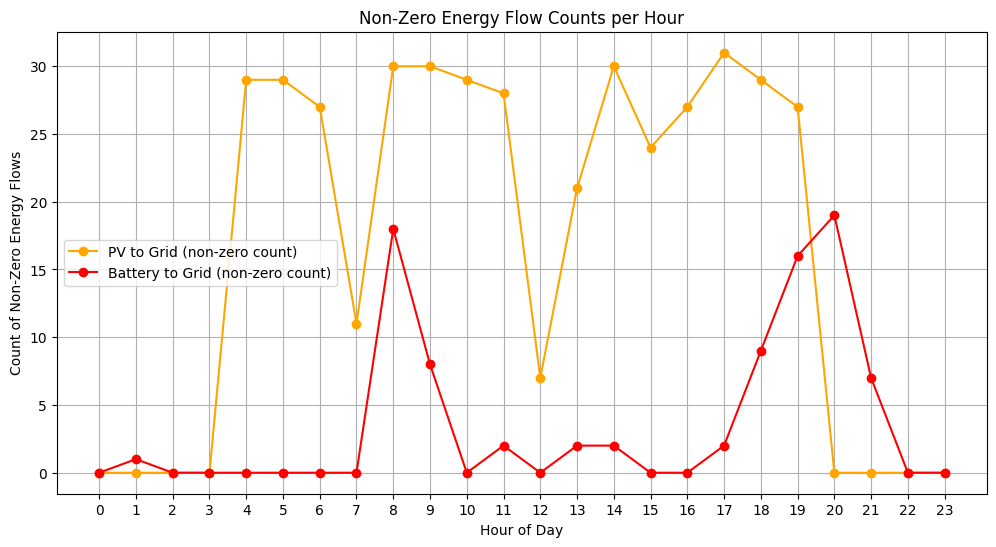

In [73]:
# --- Count non-zero PV_to_Grid and Battery_to_Grid per hour ---
non_zero_counts = df_results.groupby('Hour_of_Day')[['PV_to_Grid_MW', 'Battery_to_Grid_MW']].agg(lambda x: (x != 0).sum())

# --- Plot non-zero counts ---
plt.figure(figsize=(12,6))
plt.plot(non_zero_counts.index, non_zero_counts['PV_to_Grid_MW'], label='PV to Grid (non-zero count)', color='orange', marker='o')
plt.plot(non_zero_counts.index, non_zero_counts['Battery_to_Grid_MW'], label='Battery to Grid (non-zero count)', color='red', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Non-Zero Energy Flows')
plt.title('Non-Zero Energy Flow Counts per Hour')
plt.xticks(range(0,24))  # Add hours 0-23 to x-axis
plt.legend()
plt.grid(True)
plt.show()

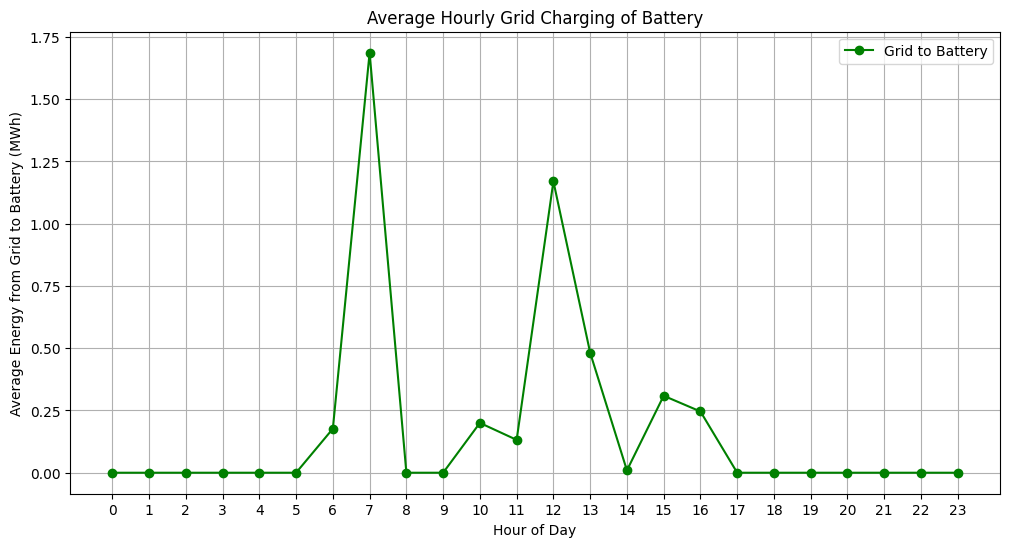

In [ ]:
# Calculate average hourly energy from Grid to Battery
hourly_grid_to_battery = df_results.groupby('Hour_of_Day')['Grid_to_Battery_MW'].mean()

# --- Plot average hourly grid-to-battery energy ---
plt.figure(figsize=(12,6))
plt.plot(hourly_grid_to_battery.index, hourly_grid_to_battery.values, marker='o', color='green', label='Grid to Battery')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy from Grid to Battery (MWh)')
plt.title('Average Hourly Grid Charging of Battery')
plt.xticks(range(0,24))  # Add hours 0-23 to x-axis
plt.grid(True)
plt.legend()
plt.show()

# Result: Line plot showing average hourly energy sent from the grid to charge the battery

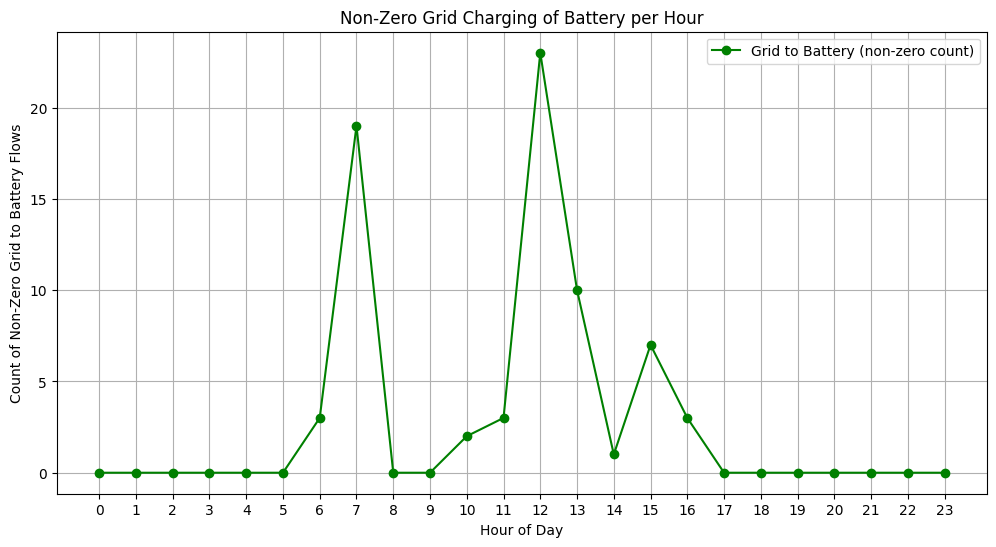

In [ ]:
# --- Count non-zero Grid_to_Battery per hour ---
non_zero_grid_to_battery = df_results.groupby('Hour_of_Day')['Grid_to_Battery_MW'].apply(lambda x: (x != 0).sum())

# --- Plot non-zero counts ---
plt.figure(figsize=(12,6))
plt.plot(non_zero_grid_to_battery.index, non_zero_grid_to_battery.values, marker='o', color='green', label='Grid to Battery (non-zero count)')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Non-Zero Grid to Battery Flows')
plt.title('Non-Zero Grid Charging of Battery per Hour')
plt.xticks(range(0,24))  # Add hours 0-23 to x-axis
plt.grid(True)
plt.legend()
plt.show()

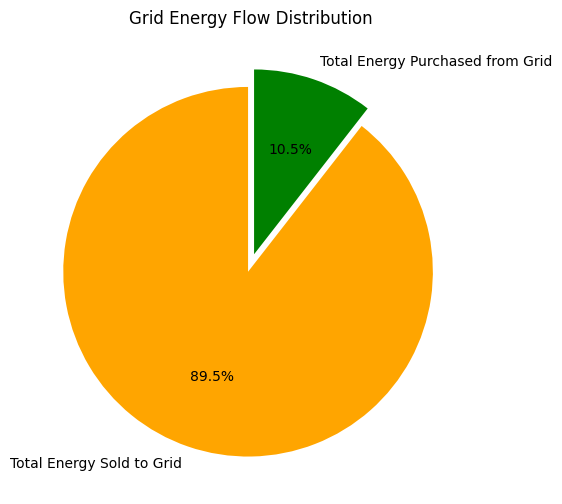

In [ ]:
# Calculate total energy sold to and purchased from the grid
total_grid_sales = df_results['PV_to_Grid_MW'].sum() + df_results['Battery_to_Grid_MW'].sum()
total_grid_purchase = df_results['Grid_to_Battery_MW'].sum()

# Prepare data and labels for pie chart
values = [total_grid_sales, total_grid_purchase]
labels = ['Total Energy Sold to Grid', 'Total Energy Purchased from Grid']
colors = ['orange', 'green']

# --- Plot pie chart showing grid energy flow distribution ---
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05, 0.05))
plt.title('Grid Energy Flow Distribution')
plt.show()

# Result: Pie chart displaying proportion of total energy sold to grid vs purchased from grid

### Battery Analysis

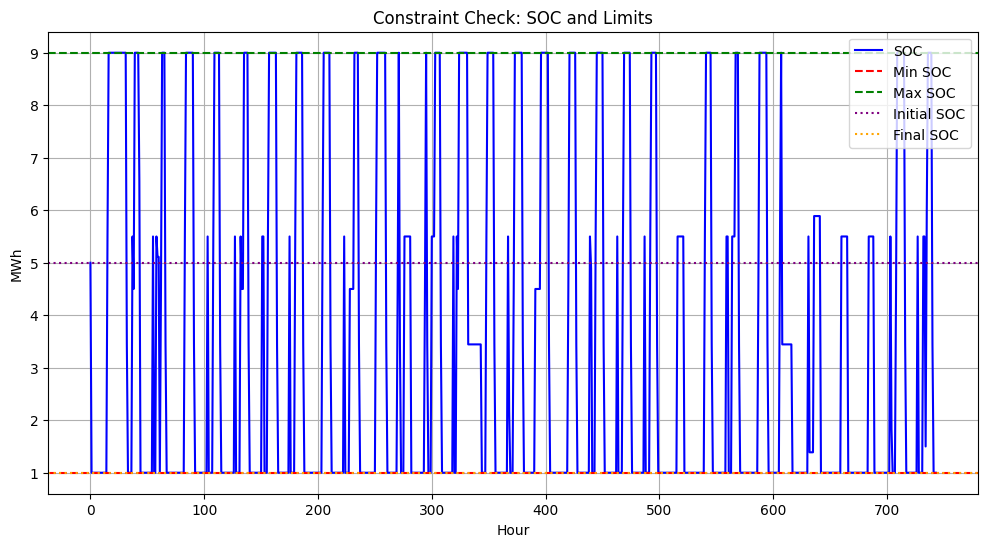

In [ ]:
# This code visualizes battery state-of-charge (SOC) over time and checks against limits

plt.figure(figsize=(12,6))

# Plot battery SOC over time
plt.plot(hours, df_results['Battery_SOC_MWh'], label="SOC", color="blue")

# Plot SOC limits and reference points
plt.axhline(y=min_soc, color="red", linestyle="--", label="Min SOC")
plt.axhline(y=max_soc, color="green", linestyle="--", label="Max SOC")
plt.axhline(y=initial_energy, color="purple", linestyle=":", label="Initial SOC")
plt.axhline(y=final_energy, color="orange", linestyle=":", label="Final SOC")

plt.title("Constraint Check: SOC and Limits")
plt.xlabel("Hour")
plt.ylabel("MWh")
plt.grid(True)

# Move legend to upper right without overlapping the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

plt.show()

# Result: Line chart showing battery SOC and its minimum, maximum, initial, and final values for constraint verification

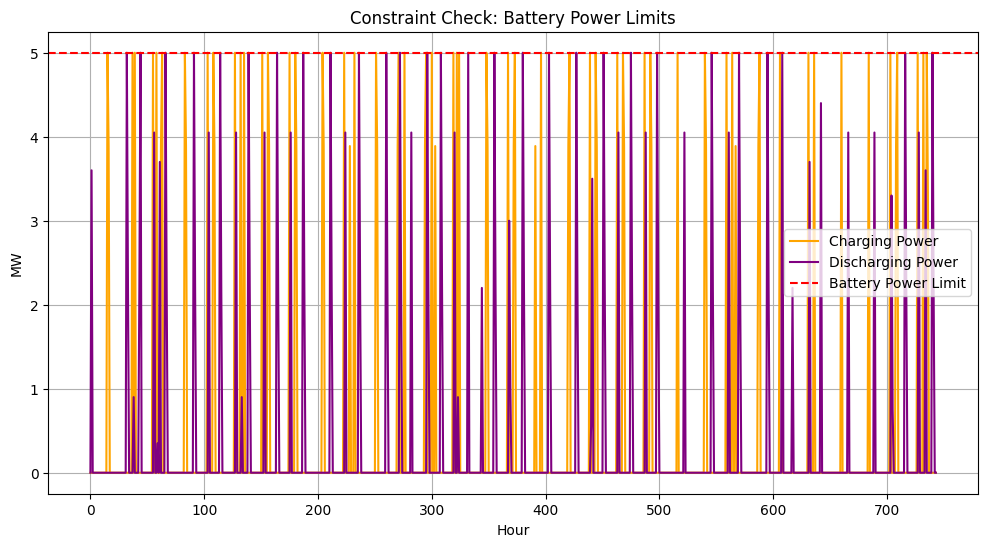

In [ ]:
# This code visualizes battery charging/discharging power and checks against power limits

plt.figure(figsize=(12,6))

# Plot total charging power (from PV + Grid)
plt.plot(hours, df_results['PV_to_Battery_MW'] + df_results['Grid_to_Battery_MW'],
         label="Charging Power", color="orange")

# Plot discharging power (to Grid)
plt.plot(hours, df_results['Battery_to_Grid_MW'],
         label="Discharging Power", color="purple")

# Plot battery power limit
plt.axhline(y=battery_power, color="red", linestyle="--", label="Battery Power Limit")

plt.title("Constraint Check: Battery Power Limits")
plt.xlabel("Hour")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()

# Result: Line chart showing battery charging/discharging powers and verification of power limit compliance

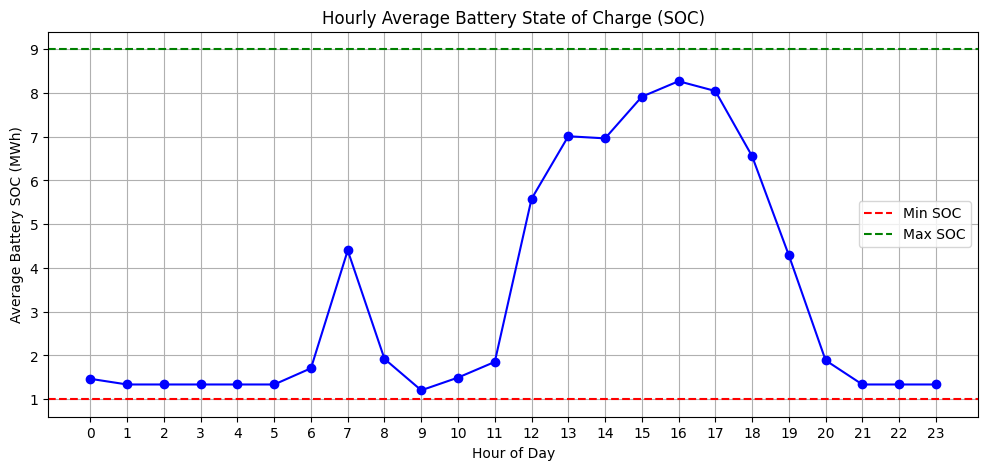

In [ ]:
# Calculate average hourly battery state of charge (SOC)
hourly_avg_soc = df_results.groupby('Hour_of_Day')['Battery_SOC_MWh'].mean()

# --- Plot average hourly battery SOC with min and max SOC lines ---
plt.figure(figsize=(12,5))
plt.plot(hourly_avg_soc.index, hourly_avg_soc.values, marker='o', color='blue')
plt.axhline(y=min_soc, color='red', linestyle='--', label='Min SOC')
plt.axhline(y=max_soc, color='green', linestyle='--', label='Max SOC')
plt.xlabel('Hour of Day')
plt.ylabel('Average Battery SOC (MWh)')
plt.title('Hourly Average Battery State of Charge (SOC)')
plt.xticks(range(0,24))  # Add hours 0-23 to x-axis
plt.legend()
plt.grid(True)
plt.show()

# Result: Line plot showing hourly average battery SOC with minimum and maximum SOC limits

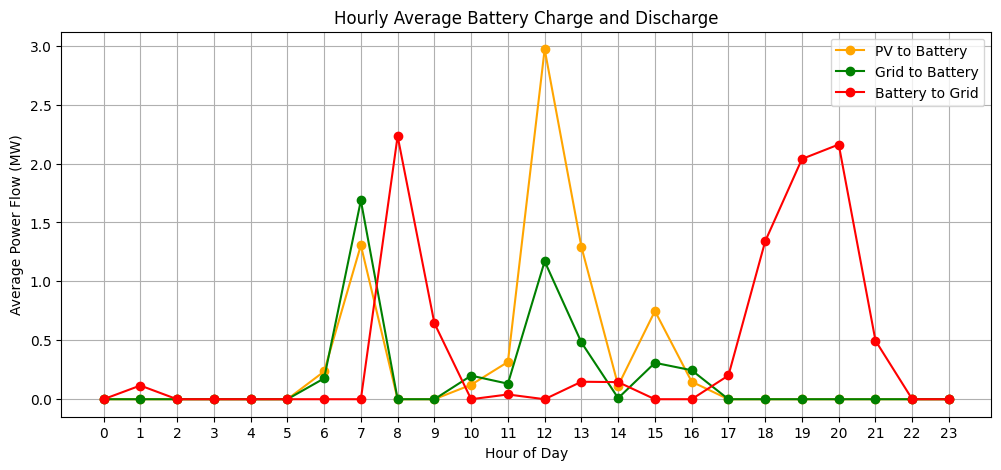

In [ ]:
# Calculate average hourly battery charge and discharge values
df_hourly = df_results.groupby('Hour_of_Day')[['PV_to_Battery_MW', 'Grid_to_Battery_MW', 'Battery_to_Grid_MW']].mean()

# --- Plot hourly average battery charging and discharging ---
plt.figure(figsize=(12,5))
plt.plot(df_hourly.index, df_hourly['PV_to_Battery_MW'], label='PV to Battery', color='orange', marker='o')
plt.plot(df_hourly.index, df_hourly['Grid_to_Battery_MW'], label='Grid to Battery', color='green', marker='o')
plt.plot(df_hourly.index, df_hourly['Battery_to_Grid_MW'], label='Battery to Grid', color='red', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power Flow (MW)')
plt.title('Hourly Average Battery Charge and Discharge')
plt.xticks(range(0,24))  # Add hours 0-23 to x-axis
plt.legend()
plt.grid(True)
plt.show()

# Result: Line plot showing average hourly battery charge (from PV and Grid) and discharge to Grid

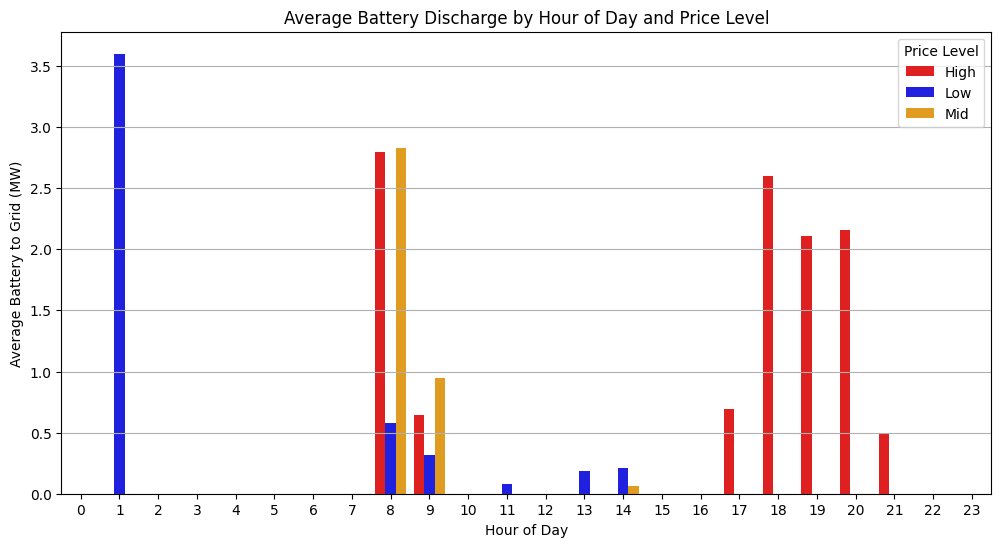

In [ ]:
# Calculate average hourly battery discharge by Price_Level
hourly_discharge_by_price = df_results.groupby(['Hour_of_Day', 'Price_Level'])['Battery_to_Grid_MW'].mean().reset_index()

# --- Plot comparative bar chart of battery discharge by hour and price level ---
plt.figure(figsize=(12,6))
sns.barplot(
    data=hourly_discharge_by_price,
    x='Hour_of_Day',
    y='Battery_to_Grid_MW',
    hue='Price_Level',
    palette={'Low':'blue', 'Mid':'orange', 'High':'red'}
)
plt.xlabel('Hour of Day')
plt.ylabel('Average Battery to Grid (MW)')
plt.title('Average Battery Discharge by Hour of Day and Price Level')
plt.xticks(range(0,24))  # Add hours 0-23 to x-axis
plt.legend(title='Price Level')
plt.grid(True, axis='y')
plt.show()

# Result: Bar chart showing how average battery discharge varies by hour and electricity price level

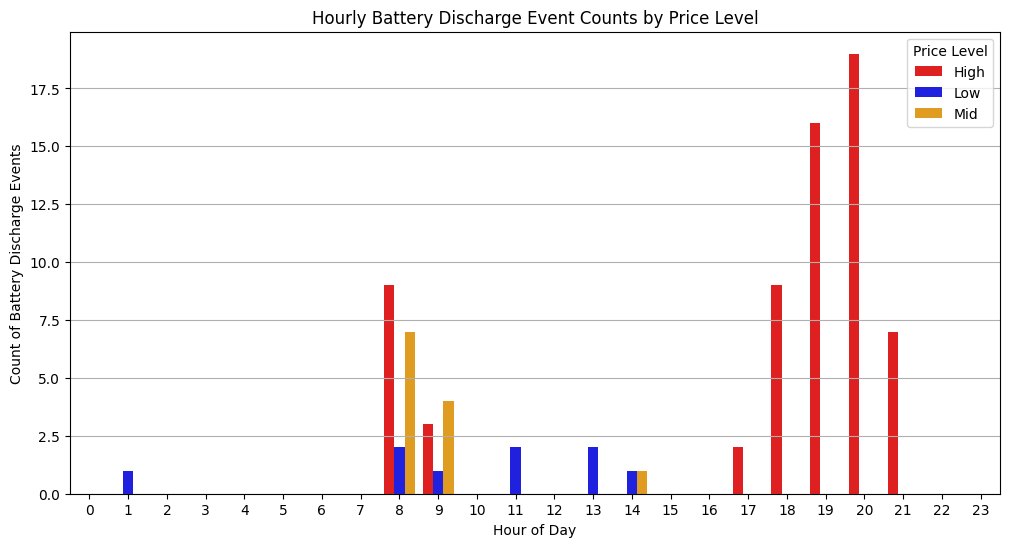

In [74]:
# Calculate hourly count of non-zero battery discharge by Price_Level
hourly_discharge_count = df_results.groupby(['Hour_of_Day', 'Price_Level'])['Battery_to_Grid_MW'].apply(lambda x: (x != 0).sum()).reset_index()

# --- Plot comparative bar chart of battery discharge counts by hour and price level ---
plt.figure(figsize=(12,6))
sns.barplot(
    data=hourly_discharge_count,
    x='Hour_of_Day',
    y='Battery_to_Grid_MW',  # now represents count of non-zero discharges
    hue='Price_Level',
    palette={'Low':'blue', 'Mid':'orange', 'High':'red'}
)
plt.xlabel('Hour of Day')
plt.ylabel('Count of Battery Discharge Events')
plt.title('Hourly Battery Discharge Event Counts by Price Level')
plt.xticks(range(0,24))
plt.legend(title='Price Level')
plt.grid(True, axis='y')
plt.show()

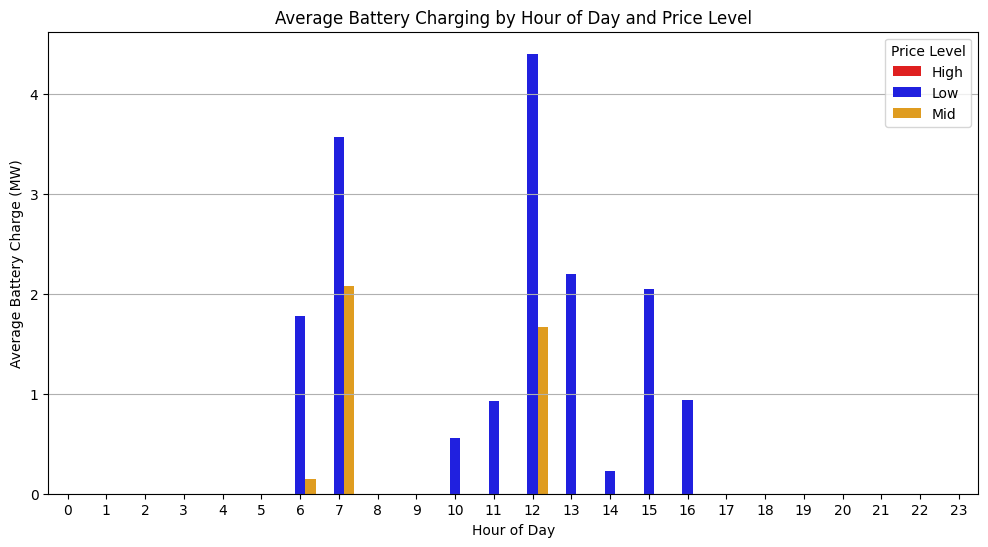

In [ ]:
# Calculate average hourly battery charge from PV and Grid by Price_Level
hourly_charge_by_price = df_results.groupby(['Hour_of_Day', 'Price_Level'])[['PV_to_Battery_MW', 'Grid_to_Battery_MW']].mean().reset_index()

# Combine PV and Grid charging into total charge
hourly_charge_by_price['Total_Charge_MW'] = hourly_charge_by_price['PV_to_Battery_MW'] + hourly_charge_by_price['Grid_to_Battery_MW']

# --- Plot comparative bar chart of total battery charge by hour and price level ---
plt.figure(figsize=(12,6))
sns.barplot(
    data=hourly_charge_by_price,
    x='Hour_of_Day',
    y='Total_Charge_MW',
    hue='Price_Level',
    palette={'Low':'blue', 'Mid':'orange', 'High':'red'}
)
plt.xlabel('Hour of Day')
plt.ylabel('Average Battery Charge (MW)')
plt.title('Average Battery Charging by Hour of Day and Price Level')
plt.xticks(range(0,24))  # Add hours 0-23 to x-axis
plt.legend(title='Price Level')
plt.grid(True, axis='y')
plt.show()

# Result: Bar chart showing how average battery charging varies by hour and electricity price level

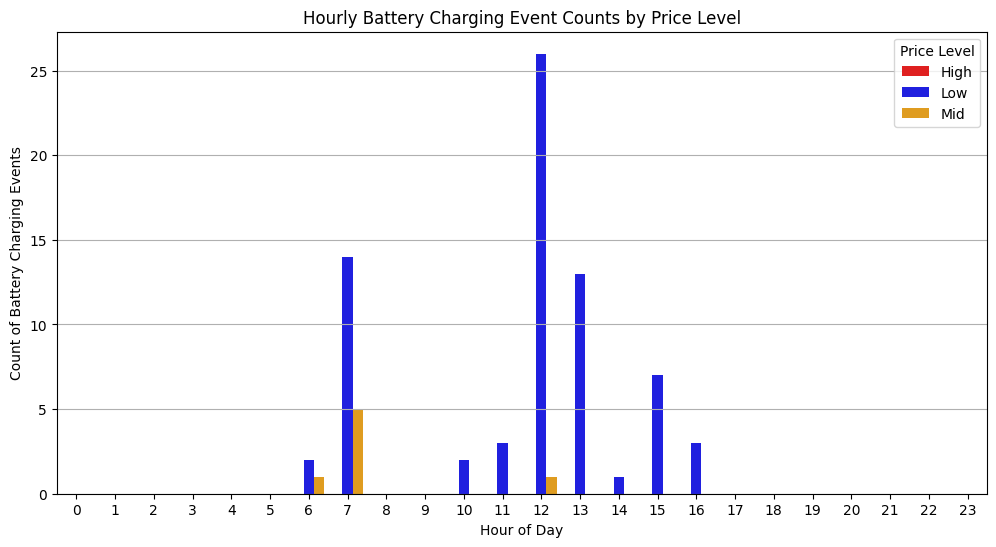

In [77]:
# Calculate hourly count of non-zero battery charging events (PV + Grid) by Price_Level
hourly_charge_count = df_results.groupby(['Hour_of_Day', 'Price_Level'])[['PV_to_Battery_MW', 'Grid_to_Battery_MW']].apply(lambda x: ((x['PV_to_Battery_MW'] + x['Grid_to_Battery_MW']) != 0).sum()).reset_index(name='Charge_Event_Count')

# --- Plot comparative bar chart of battery charging counts by hour and price level ---
plt.figure(figsize=(12,6))
sns.barplot(
    data=hourly_charge_count,
    x='Hour_of_Day',
    y='Charge_Event_Count',
    hue='Price_Level',
    palette={'Low':'blue', 'Mid':'orange', 'High':'red'}
)
plt.xlabel('Hour of Day')
plt.ylabel('Count of Battery Charging Events')
plt.title('Hourly Battery Charging Event Counts by Price Level')
plt.xticks(range(0,24))
plt.legend(title='Price Level')
plt.grid(True, axis='y')
plt.show()


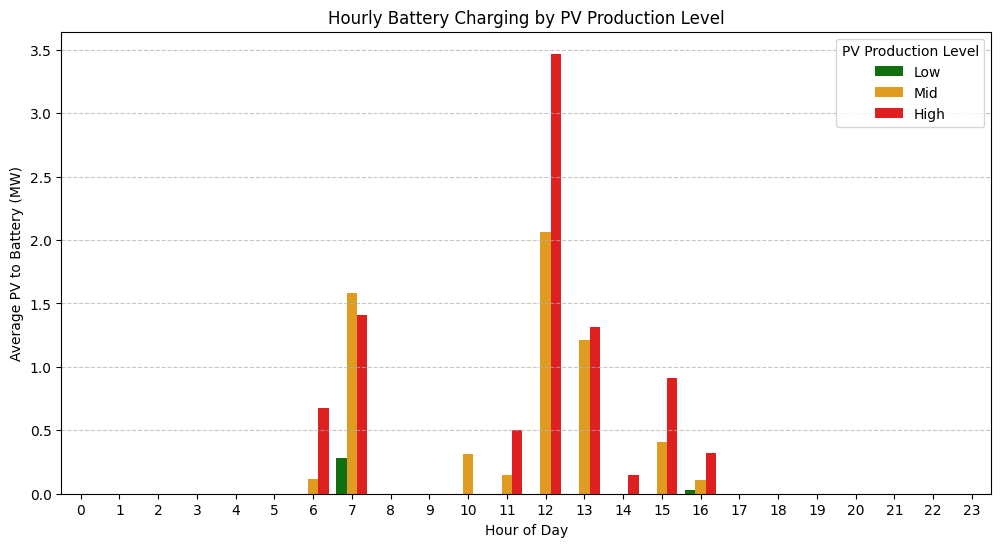

In [ ]:
# Calculate average battery charging from PV by hour and PV production level
pv_battery_grouped = df_results.groupby(['Hour_of_Day', 'Prod_Level'])['PV_to_Battery_MW'].mean().reset_index()

# --- Plot bar chart of battery charging from PV by hour and production level ---
plt.figure(figsize=(12,6))
sns.barplot(
    data=pv_battery_grouped,
    x='Hour_of_Day',
    y='PV_to_Battery_MW',
    hue='Prod_Level',
    palette={'Low':'green', 'Mid':'orange', 'High':'red'}
)
plt.xlabel('Hour of Day')
plt.ylabel('Average PV to Battery (MW)')
plt.title('Hourly Battery Charging by PV Production Level')
plt.legend(title='PV Production Level')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Result: Bar chart showing how battery charging from PV varies by hour and PV production level

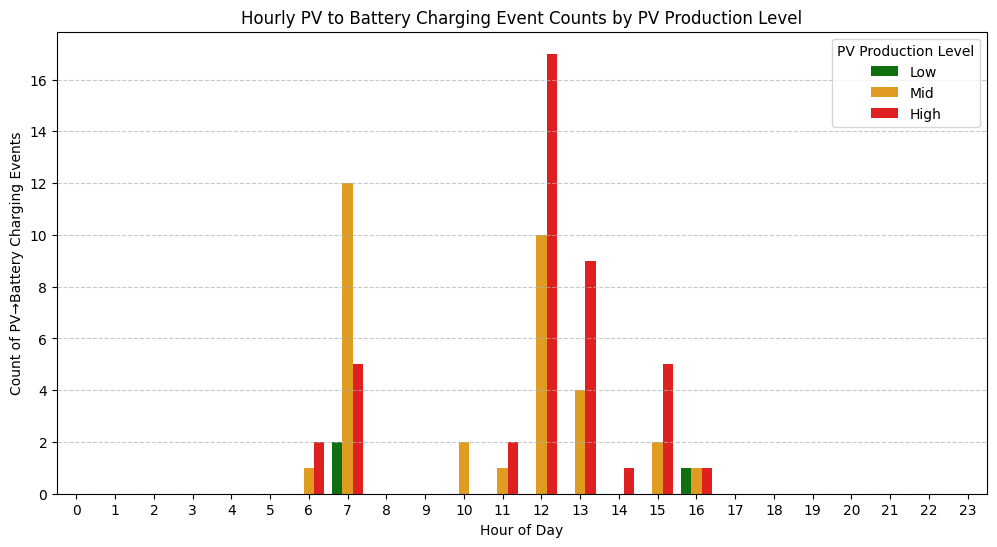

In [78]:
# Calculate hourly count of non-zero battery charging events from PV by PV production level
pv_battery_count = df_results.groupby(['Hour_of_Day', 'Prod_Level'])['PV_to_Battery_MW'].apply(lambda x: (x != 0).sum()).reset_index(name='Charge_Event_Count')

# --- Plot bar chart of battery charging event counts from PV ---
plt.figure(figsize=(12,6))
sns.barplot(
    data=pv_battery_count,
    x='Hour_of_Day',
    y='Charge_Event_Count',
    hue='Prod_Level',
    palette={'Low':'green', 'Mid':'orange', 'High':'red'}
)
plt.xlabel('Hour of Day')
plt.ylabel('Count of PV→Battery Charging Events')
plt.title('Hourly PV to Battery Charging Event Counts by PV Production Level')
plt.legend(title='PV Production Level')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


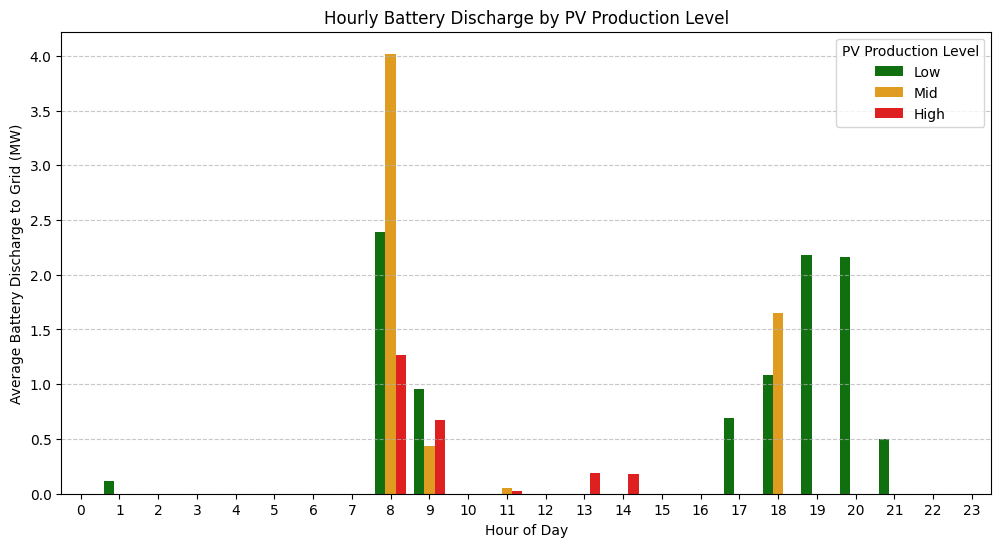

In [ ]:
# Calculate average battery discharge to grid by hour and PV production level
pv_battery_discharge_grouped = df_results.groupby(['Hour_of_Day', 'Prod_Level'])['Battery_to_Grid_MW'].mean().reset_index()

# --- Plot bar chart of battery discharge to grid by hour and PV production level ---
plt.figure(figsize=(12,6))
sns.barplot(
    data=pv_battery_discharge_grouped,
    x='Hour_of_Day',
    y='Battery_to_Grid_MW',
    hue='Prod_Level',
    palette={'Low':'green', 'Mid':'orange', 'High':'red'}
)
plt.xlabel('Hour of Day')
plt.ylabel('Average Battery Discharge to Grid (MW)')
plt.title('Hourly Battery Discharge by PV Production Level')
plt.legend(title='PV Production Level')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Result: Bar chart showing how battery discharge to grid varies by hour and PV production level

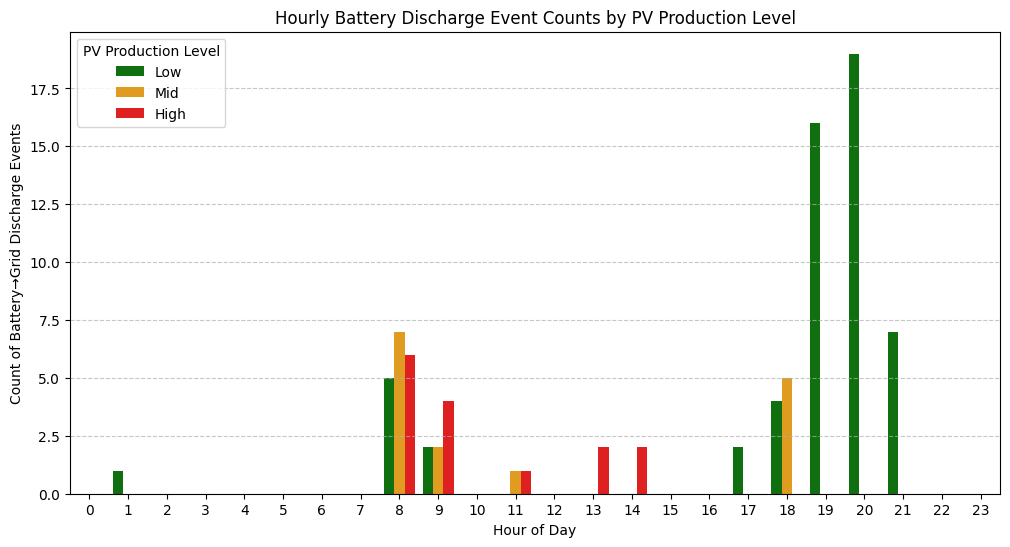

In [79]:
# Calculate hourly count of non-zero battery discharge events to grid by PV production level
pv_battery_discharge_count = df_results.groupby(['Hour_of_Day', 'Prod_Level'])['Battery_to_Grid_MW'].apply(lambda x: (x != 0).sum()).reset_index(name='Discharge_Event_Count')

# --- Plot bar chart of battery discharge event counts to grid ---
plt.figure(figsize=(12,6))
sns.barplot(
    data=pv_battery_discharge_count,
    x='Hour_of_Day',
    y='Discharge_Event_Count',
    hue='Prod_Level',
    palette={'Low':'green', 'Mid':'orange', 'High':'red'}
)
plt.xlabel('Hour of Day')
plt.ylabel('Count of Battery→Grid Discharge Events')
plt.title('Hourly Battery Discharge Event Counts by PV Production Level')
plt.legend(title='PV Production Level')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Total energy charged to the battery from PV and Grid (MWh)
charge_energy = [total_pv_charge, total_grid_charge]
labels = ['PV to Battery', 'Grid to Battery']
colors = ['orange', 'purple']

# --- Plot pie chart of battery charging sources ---
plt.figure(figsize=(6,6))
plt.pie(charge_energy, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05,0.05))
plt.title('Battery Charging Sources (Total Energy)')
plt.show()

# Result: Pie chart showing the proportion of total energy charged to the battery from PV vs Grid

NameError: name 'total_pv_charge' is not defined

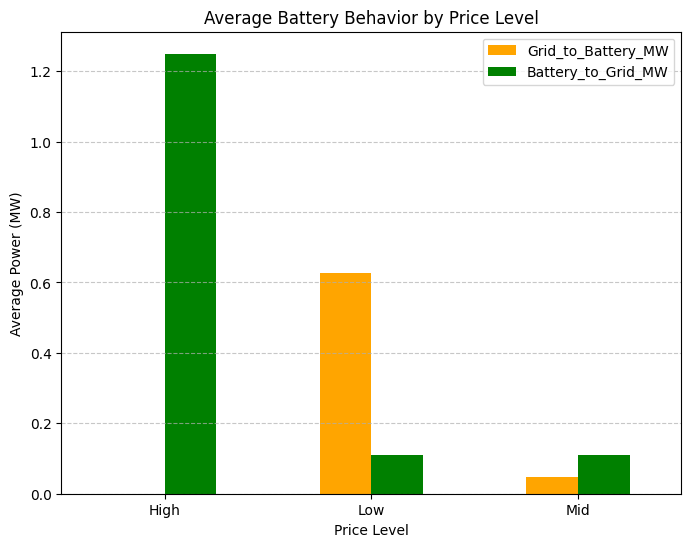

In [ ]:
# Purpose: Analyze battery behavior (charging/discharging) at different price levels (High, Mid, Low).

# ---- 1. Average battery behavior (Grid→Battery and Battery→Grid) ----
avg_behavior = df_results.groupby('Price_Level')[['Grid_to_Battery_MW', 'Battery_to_Grid_MW']].mean()

# ---- 2. Bar Chart Visualization ----
avg_behavior.plot(kind='bar', figsize=(8, 6), color=['orange', 'green'])
plt.title('Average Battery Behavior by Price Level')
plt.ylabel('Average Power (MW)')
plt.xlabel('Price Level')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Result:
# Shows how battery charging from grid and discharging to grid varies across high, mid, and low price periods.

In [ ]:
# Purpose: Calculate charging cost, discharge revenue, battery usage cost, and net profit from power flows and prices.

# Total charging cost from grid to battery
charge_cost_total = (df_results['Price_TL_per_MWh'] * df_results['Grid_to_Battery_MW']).sum()

# Total revenue from discharging battery to grid
discharge_revenue_total = (df_results['Price_TL_per_MWh'] * df_results['Battery_to_Grid_MW']).sum()

# Total battery usage cost based on discharged energy
battery_usage_total_MWh = df_results['Battery_to_Grid_MW'].sum()
battery_usage_cost_total = battery_usage_total_MWh * battery_usage_cost_per_MWh

# Net profit calculation
net_profit = discharge_revenue_total - charge_cost_total - battery_usage_cost_total

# Print summary of costs and revenues
print(f"Charging Cost (Grid→Battery): {charge_cost_total:,.2f} TL")
print(f"Discharging Revenue (Battery→Grid): {discharge_revenue_total:,.2f} TL")
print(f"Battery Usage Cost (Discharge): {battery_usage_cost_total:,.2f} TL")
print(f"Net Profit: {net_profit:,.2f} TL")

# Result: Computed financial summary of battery charge/discharge operations and net profit.

Charging Cost (Grid→Battery): 147,594.84 TL
Discharging Revenue (Battery→Grid): 938,121.20 TL
Battery Usage Cost (Discharge): 177,930.00 TL
Net Profit: 612,596.36 TL


### Behavior of Power Flows

In [ ]:
 # Purpose: Extract and rename power flow data between PV, battery, and grid for easier analysis.

# 1. Power from PV to Grid
subdf_pv_to_grid = df_results[['Hour', 'PV_to_Grid_MW']].copy()
subdf_pv_to_grid = subdf_pv_to_grid.rename(columns={'PV_to_Grid_MW': 'Power_MW'})

# 2. Power from PV to Battery
subdf_pv_to_battery = df_results[['Hour', 'PV_to_Battery_MW']].copy()
subdf_pv_to_battery = subdf_pv_to_battery.rename(columns={'PV_to_Battery_MW': 'Power_MW'})

# 3. Power from Grid to Battery
subdf_grid_to_battery = df_results[['Hour', 'Grid_to_Battery_MW']].copy()
subdf_grid_to_battery = subdf_grid_to_battery.rename(columns={'Grid_to_Battery_MW': 'Power_MW'})

# 4. Power from Battery to Grid
subdf_battery_to_grid = df_results[['Hour', 'Battery_to_Grid_MW']].copy()
subdf_battery_to_grid = subdf_battery_to_grid.rename(columns={'Battery_to_Grid_MW': 'Power_MW'})

# Print total energy transferred in MWh for each flow
print(f"Total PV→Grid: {subdf_pv_to_grid['Power_MW'].sum():.2f} MWh")
print(f"Total PV→Battery: {subdf_pv_to_battery['Power_MW'].sum():.2f} MWh")
print(f"Total Grid→Battery: {subdf_grid_to_battery['Power_MW'].sum():.2f} MWh")
print(f"Total Battery→Grid: {subdf_battery_to_grid['Power_MW'].sum():.2f} MWh")

# Result: Dataframes created with standardized column names and total energy values printed.

Total PV→Grid: 864.47 MWh
Total PV→Battery: 224.93 MWh
Total Grid→Battery: 136.73 MWh
Total Battery→Grid: 296.55 MWh


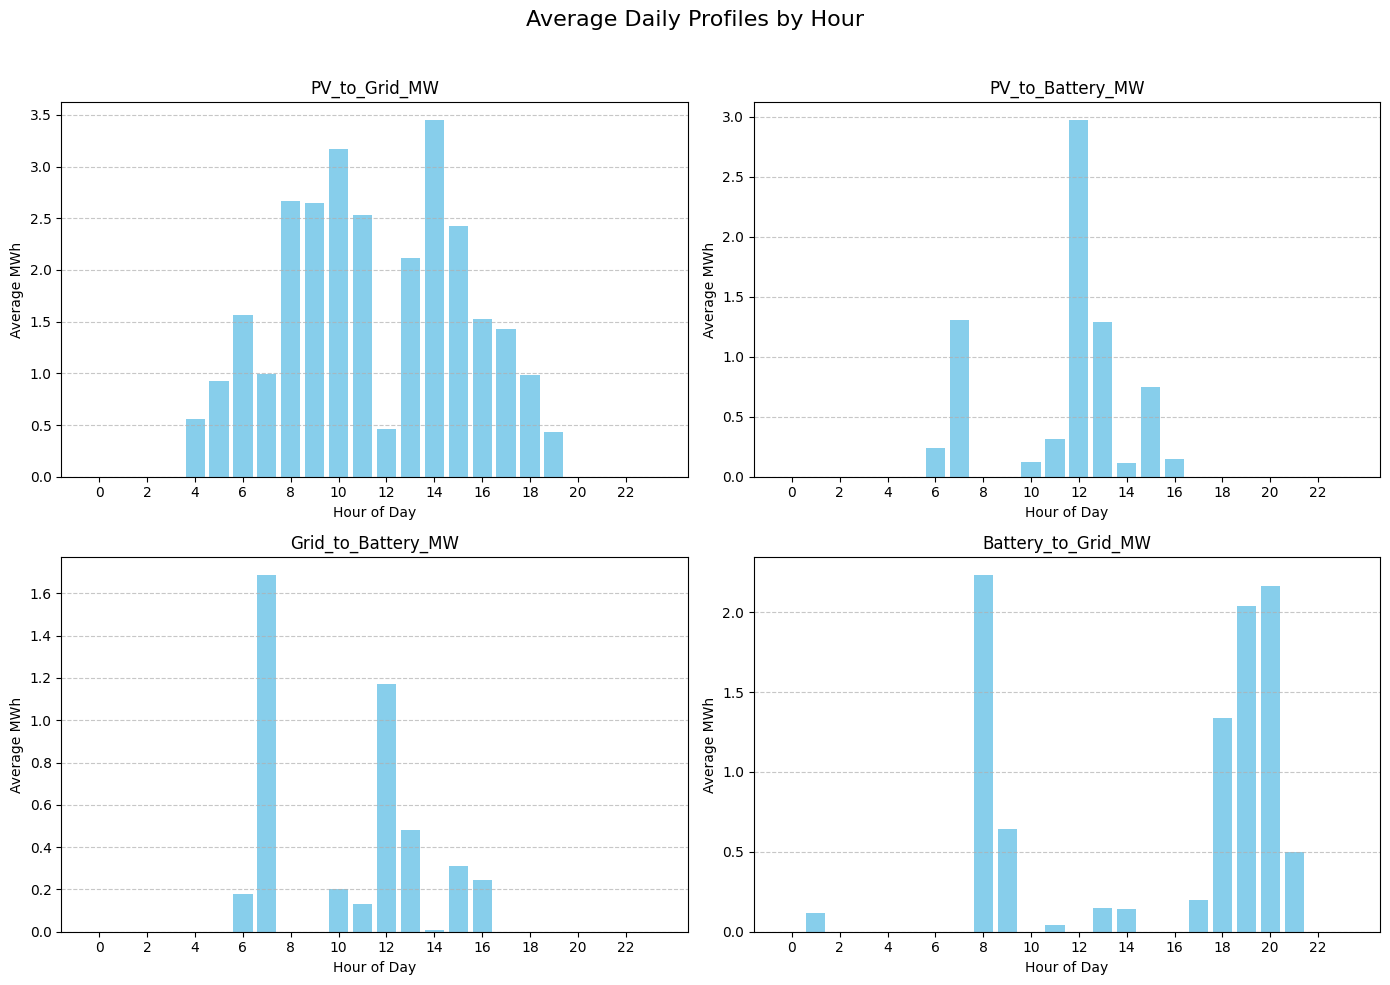

In [ ]:
# Purpose: Aggregate and visualize average hourly energy flows for a typical day using bar charts.

# Define columns to plot
cols = ['PV_to_Grid_MW', 'PV_to_Battery_MW', 'Grid_to_Battery_MW', 'Battery_to_Grid_MW']

# Create bar charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Average Daily Profiles by Hour', fontsize=16)
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].bar(df_grouped.index, df_grouped[col], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel('Average MWh')
    axes[i].set_xticks(range(0, 24, 2))
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Result: Displayed four bar charts showing average hourly behavior for different power flows.

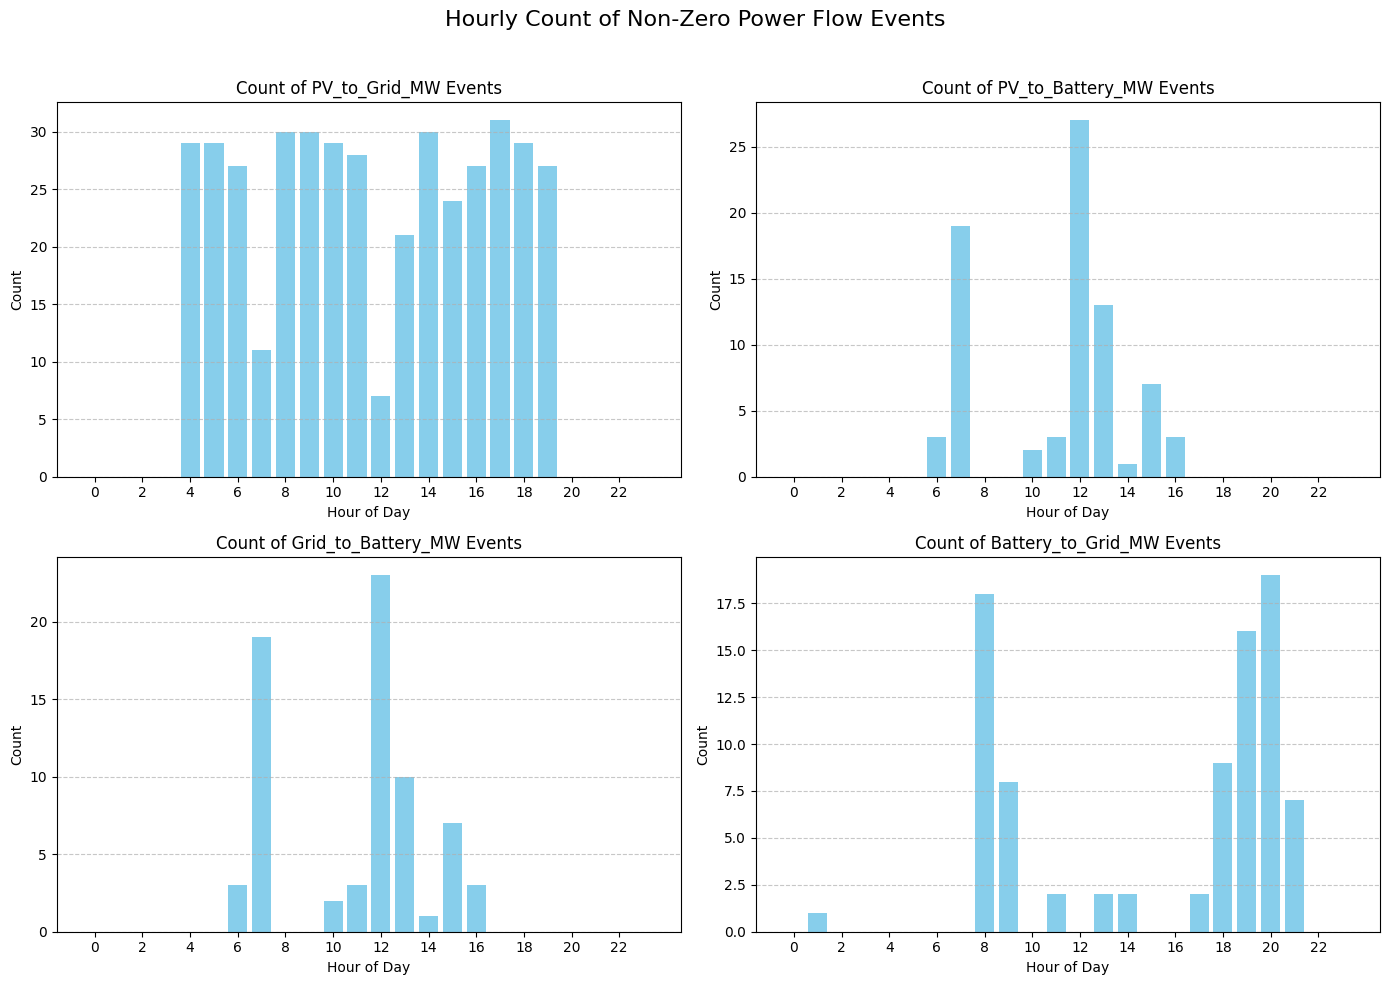

In [80]:
# Define columns for count plot
cols = ['PV_to_Grid_MW', 'PV_to_Battery_MW', 'Grid_to_Battery_MW', 'Battery_to_Grid_MW']

# Calculate hourly non-zero counts
df_counts = df_results.groupby('Hour_of_Day')[cols].apply(lambda x: (x != 0).sum())

# Create bar charts for counts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Hourly Count of Non-Zero Power Flow Events', fontsize=16)
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].bar(df_counts.index, df_counts[col], color='skyblue')
    axes[i].set_title(f'Count of {col} Events')
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(range(0, 24, 2))
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# Purpose: Visualize energy flows between PV, Battery, and Grid using a Sankey diagram.
# 1. Define nodes and flows
labels = ["PV", "Battery", "Grid"]

# Total energy flows (MWh)
pv_to_grid = df_results['PV_to_Grid_MW'].sum()
pv_to_battery = df_results['PV_to_Battery_MW'].sum()
grid_to_battery = df_results['Grid_to_Battery_MW'].sum()
battery_to_grid = df_results['Battery_to_Grid_MW'].sum()

# Source-target mapping
source = [0, 0, 1, 2]   # PV->Battery, PV->Grid, Battery->Grid, Grid->Battery
target = [1, 2, 2, 1]   # corresponding targets
value = [pv_to_battery, pv_to_grid, battery_to_grid, grid_to_battery]

# 2. Create Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=["orange", "green", "blue"]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=["orange", "orange", "green", "blue"]  # flow colors
    )
)])

fig.update_layout(title_text="Energy Flow: PV, Battery, and Grid", font_size=12)
fig.show()

# Result:
# Sankey diagram illustrates how PV production is allocated, how energy moves between battery and grid,
# and the relative magnitudes of each flow.

In [81]:
import plotly.graph_objects as go

# Labels
labels = ["PV", "Battery", "Grid"]

# Count of non-zero events for each flow
pv_to_grid_count = (df_results['PV_to_Grid_MW'] != 0).sum()
pv_to_battery_count = (df_results['PV_to_Battery_MW'] != 0).sum()
grid_to_battery_count = (df_results['Grid_to_Battery_MW'] != 0).sum()
battery_to_grid_count = (df_results['Battery_to_Grid_MW'] != 0).sum()

# Source-target mapping (same as before)
source = [0, 0, 1, 2]  # PV->Battery, PV->Grid, Battery->Grid, Grid->Battery
target = [1, 2, 2, 1]
value = [pv_to_battery_count, pv_to_grid_count, battery_to_grid_count, grid_to_battery_count]

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=["orange", "green", "blue"]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=["orange", "orange", "green", "blue"]  # flow colors
    )
)])

fig.update_layout(title_text="Count of Non-Zero Energy Flow Events: PV, Battery, and Grid", font_size=12)
fig.show()


### Total Financial Results

In [ ]:
# This code calculates total financial metrics and prints a summary table

# Compute total revenue, grid charging cost, battery usage cost, and net profit
summary = {
    "Total Revenue (TL)": df_results['Revenue_TL'].sum(),
    "Total Grid Charge Cost (TL)": df_results['Grid_Charge_Cost_TL'].sum(),
    "Total Battery Usage Cost (TL)": df_results['Battery_Usage_Cost_TL'].sum(),
    "Net Profit (TL)": df_results['Net_Profit_TL'].sum()
}

# Print financial summary
print("===== Total Financial Summary =====")
for k, v in summary.items():
    print(f"{k}: {v:,.2f}")

# Result: Console output showing total revenue, costs, and net profit

===== Total Financial Summary =====
Total Revenue (TL): 2,750,639.83
Total Grid Charge Cost (TL): 147,594.84
Total Battery Usage Cost (TL): 177,930.00
Net Profit (TL): 2,425,114.99


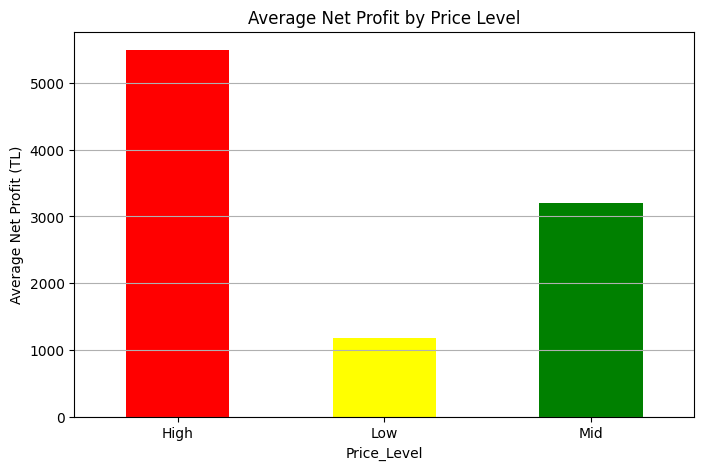

In [ ]:
# Analyze average net profit by electricity price levels (High / Mid / Low)
price_level_avg_profit = df_results.groupby('Price_Level')['Net_Profit_TL'].mean()

# --- Plot bar chart of average net profit by price level ---
plt.figure(figsize=(8,5))
price_level_avg_profit.plot(kind='bar', color=['red', 'yellow', 'green'])
plt.ylabel("Average Net Profit (TL)")
plt.title("Average Net Profit by Price Level")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Result: Bar chart showing average net profit for each electricity price level

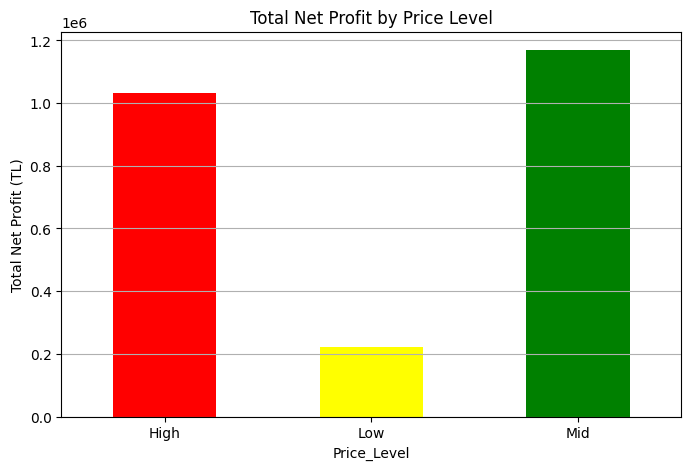

In [86]:
# Analyze total net profit by electricity price levels (High / Mid / Low)
price_level_avg_profit = df_results.groupby('Price_Level')['Net_Profit_TL'].sum()

# --- Plot bar chart of total net profit by price level ---
plt.figure(figsize=(8,5))
price_level_avg_profit.plot(kind='bar', color=['red', 'yellow', 'green'])
plt.ylabel("Total Net Profit (TL)")
plt.title("Total Net Profit by Price Level")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Result: Bar chart showing total net profit for each electricity price level

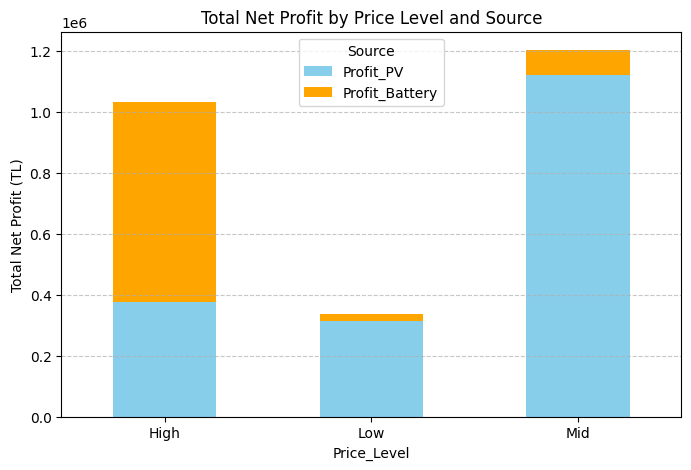

In [88]:
# Calculate net profit by source (PV and Battery) and Price_Level
df_results['Profit_PV'] = df_results['PV_to_Grid_MW'] * df_results['Price_TL_per_MWh']
df_results['Profit_Battery'] = df_results['Battery_to_Grid_MW'] * df_results['Price_TL_per_MWh'] - df_results['Battery_Usage_Cost_TL']

profit_by_source = df_results.groupby('Price_Level')[['Profit_PV', 'Profit_Battery']].sum()

# --- Plot stacked bar chart ---
profit_by_source.plot(kind='bar', stacked=True, figsize=(8,5), color=['skyblue', 'orange'])
plt.ylabel("Total Net Profit (TL)")
plt.title("Total Net Profit by Price Level and Source")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Source')
plt.show()

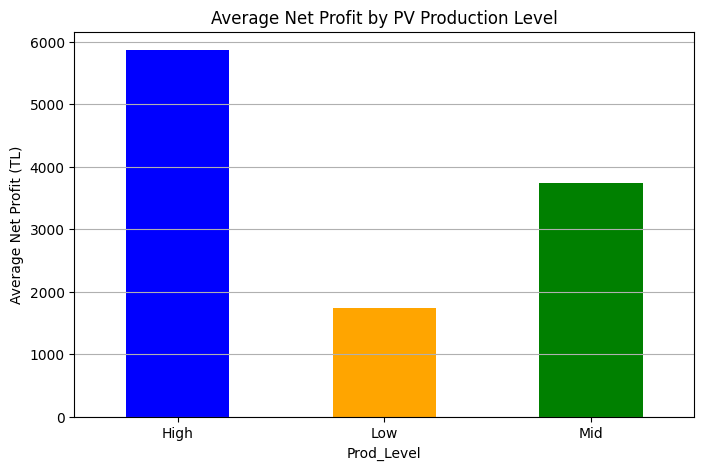

In [ ]:
# Analyze average net profit by PV production levels (High / Mid / Low)
prod_level_avg_profit = df_results.groupby('Prod_Level')['Net_Profit_TL'].mean()

# --- Plot bar chart of average net profit by PV production level ---
plt.figure(figsize=(8,5))
prod_level_avg_profit.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.ylabel("Average Net Profit (TL)")
plt.title("Average Net Profit by PV Production Level")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Result: Bar chart showing average net profit for each PV production level

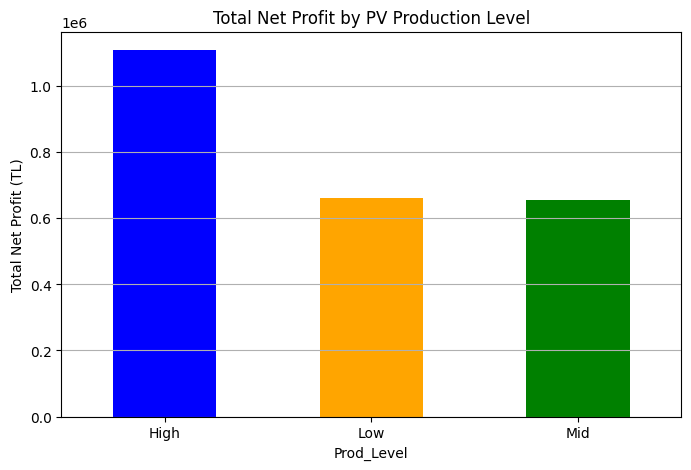

In [87]:
# Analyze total net profit by PV production levels (High / Mid / Low)
prod_level_avg_profit = df_results.groupby('Prod_Level')['Net_Profit_TL'].sum()

# --- Plot bar chart of total net profit by PV production level ---
plt.figure(figsize=(8,5))
prod_level_avg_profit.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.ylabel("Total Net Profit (TL)")
plt.title("Total Net Profit by PV Production Level")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Result: Bar chart showing total net profit for each PV production level

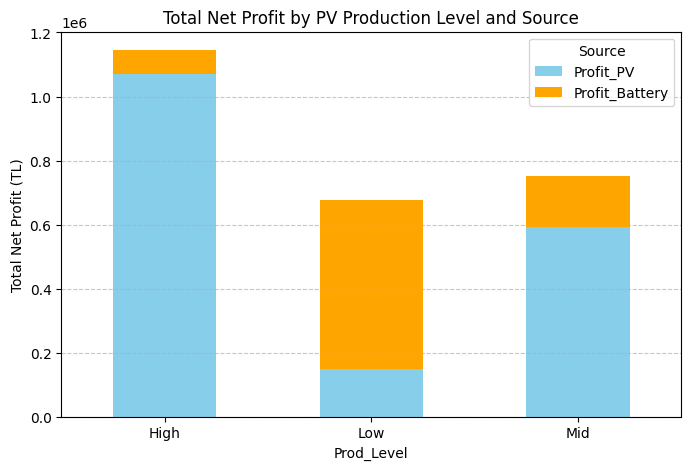

In [89]:
# Calculate net profit by source (PV and Battery) and PV production level
df_results['Profit_PV'] = df_results['PV_to_Grid_MW'] * df_results['Price_TL_per_MWh']
df_results['Profit_Battery'] = df_results['Battery_to_Grid_MW'] * df_results['Price_TL_per_MWh'] - df_results['Battery_Usage_Cost_TL']

profit_by_source_prod = df_results.groupby('Prod_Level')[['Profit_PV', 'Profit_Battery']].sum()

# --- Plot stacked bar chart ---
profit_by_source_prod.plot(kind='bar', stacked=True, figsize=(8,5), color=['skyblue', 'orange'])
plt.ylabel("Total Net Profit (TL)")
plt.title("Total Net Profit by PV Production Level and Source")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Source')
plt.show()


In [ ]:
# Purpose: Calculate total financial results including revenues, costs, and net profit, then print summaries.

total_revenue = sum(model.price[t] * (model.pv_to_grid[t].value + model.battery_to_grid[t].value) for t in model.T)
total_charge_cost = sum(model.price[t] * model.grid_to_battery[t].value for t in model.T)
total_battery_use_cost = sum(model.battery_to_grid[t].value * usage_cost for t in model.T)

net_profit = total_revenue - total_charge_cost - total_battery_use_cost

print(f"\nTotal Battery Usage (Discharge Amount): {total_discharge:.2f} MWh")
print(f"Total Financial Revenue (Net Profit): {net_profit:.2f} TL")
print(f"Total Battery Usage Cost: {total_battery_use_cost:.2f} TL")
print(f"Total Grid-to-Battery Charging Cost: {total_charge_cost:.2f} TL")
# Result: Printed financial summary showing revenue, costs, and net profit of the battery and PV system.


Total Battery Usage (Discharge Amount): 296.55 MWh
Total Financial Revenue (Net Profit): 2425114.99 TL
Total Battery Usage Cost: 177930.00 TL
Total Grid-to-Battery Charging Cost: 147594.84 TL
